In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import diffimTests as dit

import warnings
warnings.filterwarnings('ignore')

First set a baseline for detection of 5-sigma sources on varying static source density and without re-fitting PSFS.

Note this is for `templateNoNoise=True` and `skyLimited=True` !!!

In [2]:
testResults1, testResults2 = dit.loadObjects("tmp5_pkl")

In [3]:
import pandas as pd
methods = ['ALstack', 'ZOGY', 'SZOGY', 'ALstack_decorr']

tr2 = [tr for tr in testResults2 if tr['result'] is not None]
print len(testResults2), len(tr2)

250 249


In [4]:
TP1 = []; FP1 = []; FN1 = []
for i, tr in enumerate(tr2):    
    FN = {key: tr['result'][key]['FN'] for key in methods}
    FN['n_sources'] = tr['n_sources']
    FN1.append(pd.DataFrame(FN, index=[0]))

    TP = {key: tr['result'][key]['TP'] for key in methods}
    TP['n_sources'] = tr['n_sources']
    TP1.append(pd.DataFrame(TP, index=[0]))

    FP = {key: tr['result'][key]['FP'] for key in methods}
    FP['n_sources'] = tr['n_sources']
    FP1.append(pd.DataFrame(FP, index=[0]))

FN1 = pd.concat(FN1, axis=0).groupby('n_sources').median()
TP1 = pd.concat(TP1, axis=0).groupby('n_sources').median()
FP1 = pd.concat(FP1, axis=0).groupby('n_sources').median()
dit.sizeme(FN1.head())

<diffimTests.utils.sizeme instance at 0x11e0352d8>

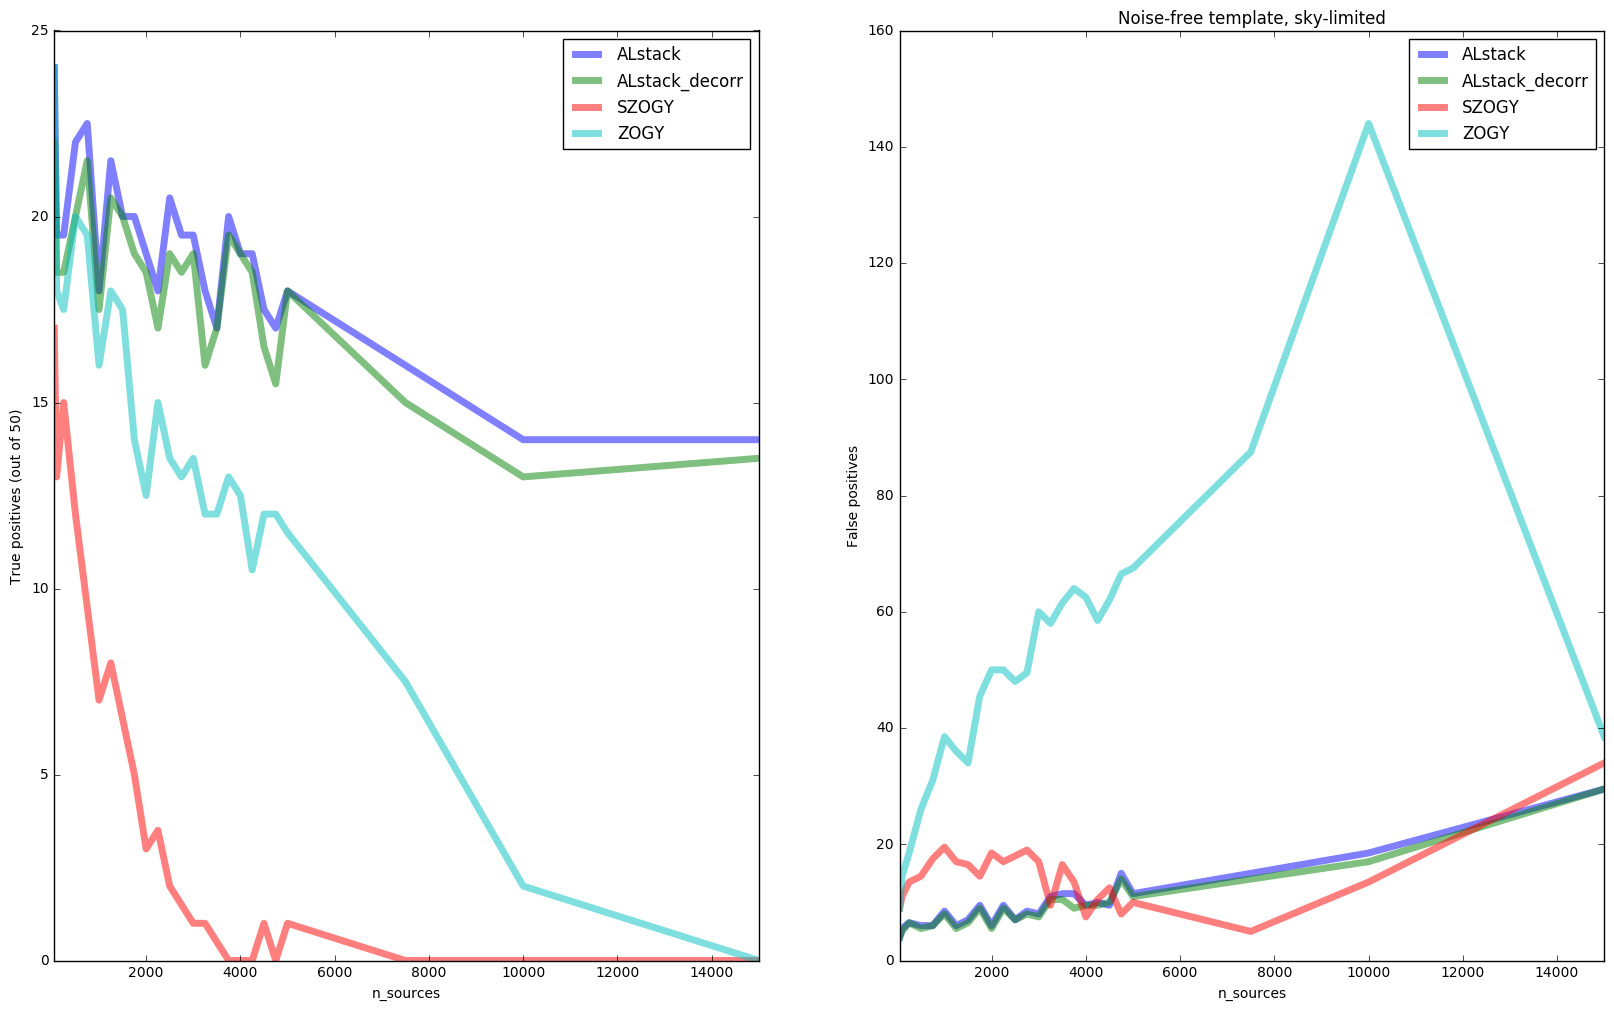

In [5]:
plt.subplots(3, 2, figsize=(20, 12))
ax = plt.subplot(121)    
TP1.reset_index().plot(x='n_sources', alpha=0.5, lw=5, ax=ax)
ax.set_ylabel('True positives (out of 50)')
ax = plt.subplot(122)    
FP1.reset_index().plot(x='n_sources', alpha=0.5, lw=5, ax=ax)
ax.set_ylabel('False positives')
ax.set_title('Noise-free template, sky-limited')

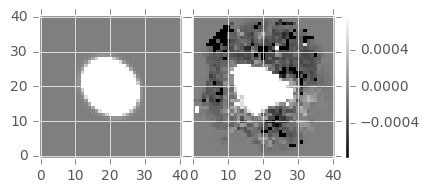

In [8]:
tr = tr2[248]
dit.plotImageGrid((tr['psfInfo']['inputPsf2'], tr['psfInfo']['psf2']))

In [2]:
n_runs = 10
ns = np.append(np.insert(np.arange(500, 5001, 250), 0, [50, 100, 250]), [7500, 10000, 15000])
varSourceFlux = [620.]
nStaticSources = ns

inputs = [(f, ns, seed) for f in varSourceFlux for ns in nStaticSources
              for seed in np.arange(66, 66+n_runs, 1)]
print len(inputs)
i = inputs[170]
i

250


(620.0, 4000, 66)

In [15]:
testResults = dit.multi.runTest(flux=i[0], n_varSources=50, n_sources=i[1], seed=i[2],
                                templateNoNoise=False, skyLimited=True,
                                sky=[30., 300.], sourceFluxRange=(500,30000),
                                 remeasurePsfs=[True, True], avoidAllOverlaps=0., 
                                returnObj=True)

N SOURCES: 643
N SOURCES: 393


In [16]:
testResults['result']

{'ALstack': {'FN': 30, 'FP': 9, 'TP': 20},
 'ALstack_decorr': {'FN': 34, 'FP': 8, 'TP': 16},
 'SZOGY': {'FN': 47, 'FP': 123, 'TP': 3},
 'ZOGY': {'FN': 41, 'FP': 166, 'TP': 9},
 'sources': {'ALstack': <lsst.afw.table.tableLib.SourceCatalog; proxy of <Swig Object of type 'lsst::afw::table::SortedCatalogT< lsst::afw::table::SourceRecord > *' at 0x1241d1ba0> >,
  'ALstack_decorr': <lsst.afw.table.tableLib.SourceCatalog; proxy of <Swig Object of type 'lsst::afw::table::SortedCatalogT< lsst::afw::table::SourceRecord > *' at 0x125aa7990> >,
  'SZOGY': <lsst.afw.table.tableLib.SourceCatalog; proxy of <Swig Object of type 'lsst::afw::table::SortedCatalogT< lsst::afw::table::SourceRecord > *' at 0x125aa75d0> >,
  'ZOGY': <lsst.afw.table.tableLib.SourceCatalog; proxy of <Swig Object of type 'lsst::afw::table::SortedCatalogT< lsst::afw::table::SourceRecord > *' at 0x1241d1690> >}}

In [17]:
testObj = testResults['obj']
sources = dit.catalogToDF(testResults['result']['sources']['ALstack'])
dit.sizeme(sources[['base_PeakCentroid_x', 'base_PeakCentroid_y']].head())

<diffimTests.utils.sizeme instance at 0x12443ae18>

(-0.0060676444787835715, -0.14306191589282966)
1.0
1.00000071962
1.0
(-0.070138554147438414, -0.19786320820352499)
(-4.9873299934333204e-17, 1.1102230246251565e-16)
(-0.0060676444787835715, -0.14306191589282966)


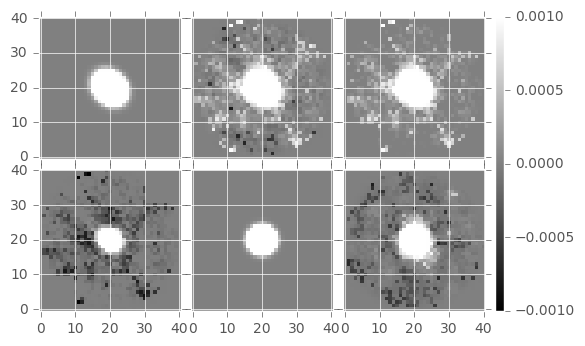

In [18]:
print testResults['psfInfo']['moments2']
print testResults['psfInfo']['inputPsf2'].sum()
print testResults['psfInfo']['psf2'].sum()
print testObj.im2.psf.sum()
print dit.psf.computeMoments(testObj.im2.psf)
print dit.psf.computeMoments(testResults['psfInfo']['inputPsf2'])
print dit.psf.computeMoments(testResults['psfInfo']['psf2'])
#psf2 = dit.psf.recenterPsf(testResults['psfInfo']['psf2'])
#print dit.psf.computeMoments(psf2)
dit.plotImageGrid((testResults['psfInfo']['inputPsf2'], testResults['psfInfo']['psf2'],
                   testObj.im2.psf,
                  testResults['psfInfo']['inputPsf2'] - testObj.im2.psf,
                  testResults['psfInfo']['inputPsf1'], testResults['psfInfo']['psf1']), clim=(-0.001, 0.001))

A&L(dec): stats(mean=0.9946534, stdev=18.715218, min=-73.084244, max=98.023216)
ZOGY: stats(mean=-0.37570155122501131, stdev=20.373458426814366, min=-97.824661938891452, max=213.480072031719)
A&L(dec) - ZOGY: stats(mean=1.4233093811497501, stdev=22.31000516796168, min=-190.11853339228657, max=97.512963538687544)
A&L(dec) - A&L: stats(mean=-0.0058061481, stdev=0.82190299, min=-4.1083755, max=5.1743011)


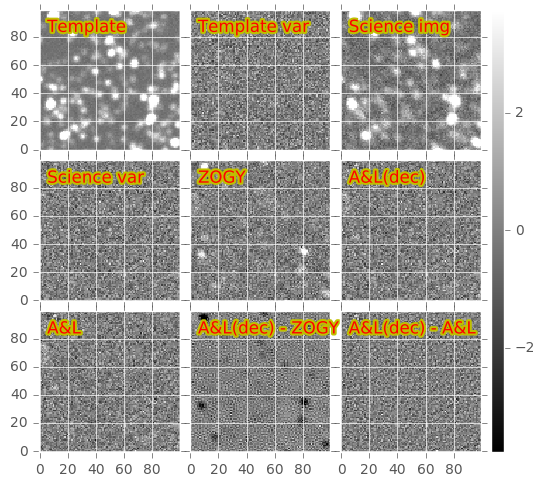

In [19]:
testObj.doPlot(centroidCoord=[398, 196, 50]);

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import diffimTests as dit

import warnings
warnings.filterwarnings('ignore')

In [12]:
testResults = dit.multi.runTest(flux=np.linspace(500., 2000., 50), 
                                n_varSources=1, n_sources=400, seed=66,
                                templateNoNoise=False, skyLimited=True,
                                sky=[30., 300.], sourceFluxRange=(500,30000),
                                remeasurePsfs=[False, True], avoidAllOverlaps=0., 
                                returnObj=True)

In [13]:
testResults['result']

{'ALstack': {'FN': 13, 'FP': 5, 'TP': 37},
 'ALstack_decorr': {'FN': 14, 'FP': 4, 'TP': 36},
 'SZOGY': {'FN': 18, 'FP': 30, 'TP': 32},
 'ZOGY': {'FN': 15, 'FP': 39, 'TP': 35},
 'sources': {'ALstack': <lsst.afw.table.tableLib.SourceCatalog; proxy of <Swig Object of type 'lsst::afw::table::SortedCatalogT< lsst::afw::table::SourceRecord > *' at 0x1245f9480> >,
  'ALstack_decorr': <lsst.afw.table.tableLib.SourceCatalog; proxy of <Swig Object of type 'lsst::afw::table::SortedCatalogT< lsst::afw::table::SourceRecord > *' at 0x127bc1570> >,
  'SZOGY': <lsst.afw.table.tableLib.SourceCatalog; proxy of <Swig Object of type 'lsst::afw::table::SortedCatalogT< lsst::afw::table::SourceRecord > *' at 0x1245f1e10> >,
  'ZOGY': <lsst.afw.table.tableLib.SourceCatalog; proxy of <Swig Object of type 'lsst::afw::table::SortedCatalogT< lsst::afw::table::SourceRecord > *' at 0x1245f1ab0> >}}

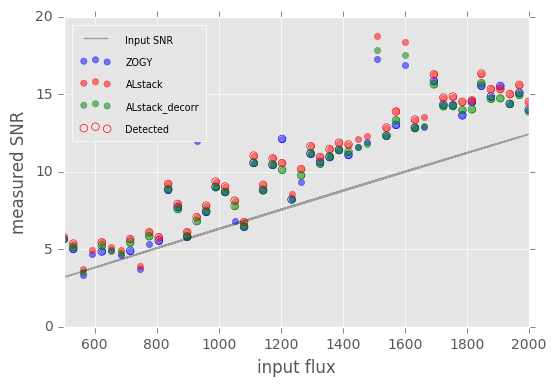

In [14]:
testObj = testResults['obj']
df1, _ = testObj.doPlotWithDetectionsHighlighted(testResults['result'])
plt.xlim(500, 2000); plt.ylim(0, 20.);

In [15]:
testResults2 = dit.multi.runTest(flux=np.linspace(500., 2000., 50), 
                                n_varSources=1, n_sources=400, seed=66,
                                templateNoNoise=False, skyLimited=True,
                                sky=[30., 300.], sourceFluxRange=(500,30000),
                                 remeasurePsfs=[False, False], avoidAllOverlaps=0., 
                                returnObj=True)

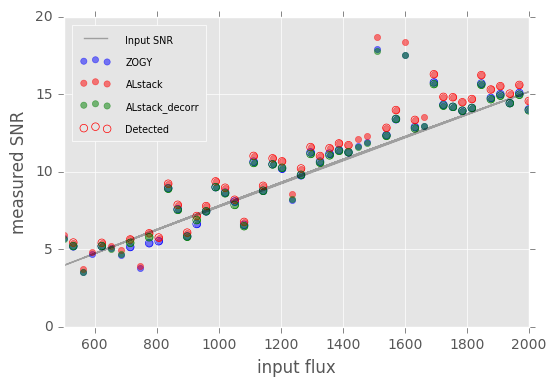

In [16]:
testObj2 = testResults2['obj']
df2, _ = testObj2.doPlotWithDetectionsHighlighted(testResults2['result'])
plt.xlim(500, 2000); plt.ylim(0, 20.);

(-2.7755575615628914e-17, 0.0)
(-2.7755575615628914e-17, 0.0)
(0.027525266114835883, -0.27490680583299953)
(-4.9873299934333204e-17, 1.1102230246251565e-16)
1.0
1.0
1.0
1.0


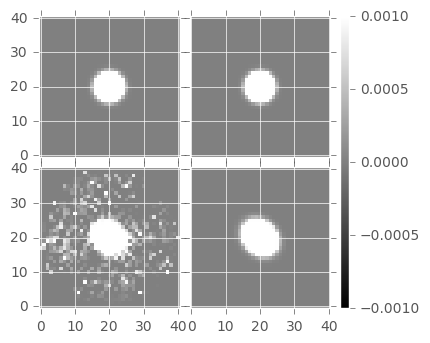

In [17]:
print dit.psf.computeMoments(testObj.im1.psf)
print dit.psf.computeMoments(testObj2.im1.psf)
print dit.psf.computeMoments(testObj.im2.psf)
print dit.psf.computeMoments(testObj2.im2.psf)
print testObj.im1.psf.sum()
print testObj2.im1.psf.sum()
print testObj.im2.psf.sum()
print testObj2.im2.psf.sum()

dit.plotImageGrid((testObj.im1.psf, testObj2.im1.psf,
                  testObj.im2.psf, testObj2.im2.psf), clim=(-0.001, 0.001))

In [18]:
dit.sizeme(df1.head())

<diffimTests.utils.sizeme instance at 0x11e2f6d40>

0.0


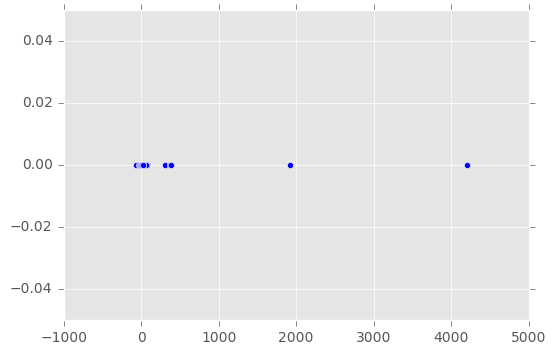

In [22]:
print ((df2.templateFlux-df1.templateFlux)/df1.templateFlux).median()
plt.scatter(df1.templateFlux, (df2.templateFlux-df1.templateFlux)/df1.templateFlux)
plt.ylim(-0.05, 0.05);

-0.143404300077


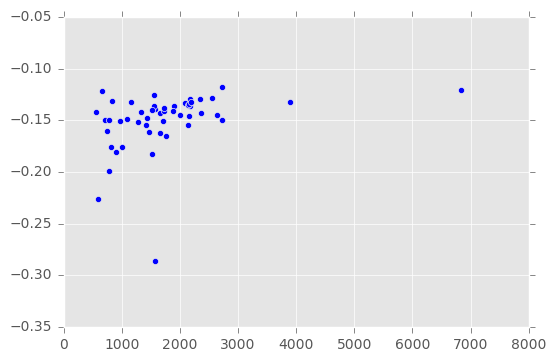

In [20]:
print ((df2.scienceFlux-df1.scienceFlux)/df1.scienceFlux).median()
plt.scatter(df1.scienceFlux, (df2.scienceFlux-df1.scienceFlux)/df1.scienceFlux)

0.229071702414
0.00448247973343


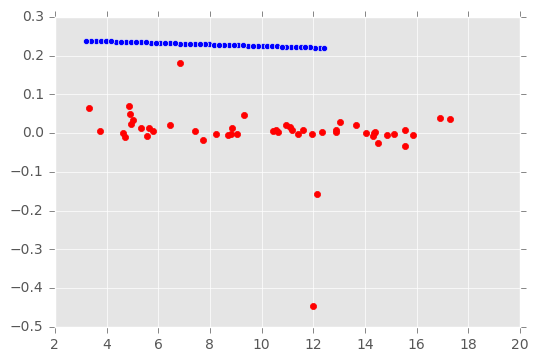

In [55]:
print ((df2.inputSNR-df1.inputSNR)/df1.inputSNR).median()
plt.scatter(df1.inputSNR, (df2.inputSNR-df1.inputSNR)/df1.inputSNR)

print ((df2.ZOGY_SNR-df1.ZOGY_SNR)/df1.ZOGY_SNR).median()
plt.scatter(df1.ZOGY_SNR, (df2.ZOGY_SNR-df1.ZOGY_SNR)/df1.ZOGY_SNR, color='r')

In [29]:
s1 = dit.catalogToDF(testResults['result']['sources']['ALstack'])
print s1.shape
print df1.shape
#s1.columns.values
s1a = s1[['base_GaussianCentroid_x', 'base_GaussianCentroid_y',
              'base_PsfFlux_flux', 'base_PsfFlux_fluxSigma']]
dit.sizeme(s1a.head())

(43, 140)
(50, 19)


<diffimTests.utils.sizeme instance at 0x1239438c0>

In [28]:
df1a = df1[['inputCentroid_x','inputCentroid_y','ZOGY_flux','ZOGY_fluxSigma',
            'inputSNR','ZOGY_SNR']]
dit.sizeme(df1a.head())

<diffimTests.utils.sizeme instance at 0x12d091758>

In [41]:
offsets = dit.catalog.computeOffsets(s1a, df1a, tmp=True)
print offsets
print offsets[0].mean(), offsets[1].mean()
print np.sum(offsets[0]<0.), np.sum(offsets[1]>0.)
print offsets[0].std(), offsets[1].std()
print len(offsets[0])

(array([-0.37780752, -0.11726413, -0.00835285, -0.31237021,  0.50541489,
        0.18405204, -0.03751219, -0.45838481, -0.33171618,  0.45422174,
       -0.2624464 ,  0.22841924,  0.13513034, -0.32682855, -0.31149123,
        0.27855623,  0.20940341, -0.56645324,  0.14871767, -0.23235996,
        0.31152124, -0.07353316, -0.3895717 ,  0.16598627, -0.03690067,
       -0.11201529, -0.04309803, -0.21973758,  0.1811925 , -0.41825444,
       -0.19280057]), array([-0.08078073,  0.15631381,  0.1244044 ,  0.13455646,  0.07704192,
       -0.05822305,  0.10538768,  0.04830011,  0.22392676, -0.30273125,
        0.31561924,  0.22177959, -0.11722715,  0.11411369,  0.34791578,
       -0.0518546 ,  0.12264513,  0.20742625, -0.23766665,  0.00965464,
        0.12729196,  0.38519662,  0.06597786,  0.06616011,  0.14259195,
       -0.08452237, -0.25323779,  0.07200072, -0.0536365 ,  0.4175308 ,
        0.18007184]))
-0.0653639715484 0.0782589427005
20 22
0.277734121176 0.173476613987
31


In [40]:
from scipy.stats import binom
rv = binom(31, 0.5)
rv.cdf(0.65)

4.6566128730773926e-10

in R:
```
> pbinom(20,31,0.5,lower=F)
[1] 0.03537777
> pbinom(22,31,0.5,lower=F)
[1] 0.00533692
```

OK actually not that much of a problem.

Now let's debug the SZOGY images. Load the results from notebook 32. a.

In [ ]:
testResults1, testResults2 = dit.loadObjects('tmp5_pkl')

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import diffimTests as dit

import warnings
warnings.filterwarnings('ignore')

In [2]:
testResults3 = dit.multi.runTest(flux=np.linspace(500., 2000., 50), 
                                n_varSources=1, n_sources=2000, seed=66,
                                templateNoNoise=False, skyLimited=True,
                                sky=[30., 300.], sourceFluxRange=(500,30000),
                                remeasurePsfs=[False, True], avoidAllOverlaps=0., 
                                returnObj=True)
testObj3 = testResults3['obj']
print testResults3['result']

{'ZOGY': {'FP': 87, 'FN': 21, 'TP': 29}, 'ALstack': {'FP': 3, 'FN': 12, 'TP': 38}, 'SZOGY': {'FP': 60, 'FN': 22, 'TP': 28}, 'sources': {'ZOGY': <lsst.afw.table.tableLib.SourceCatalog; proxy of <Swig Object of type 'lsst::afw::table::SortedCatalogT< lsst::afw::table::SourceRecord > *' at 0x12114f0c0> >, 'ALstack': <lsst.afw.table.tableLib.SourceCatalog; proxy of <Swig Object of type 'lsst::afw::table::SortedCatalogT< lsst::afw::table::SourceRecord > *' at 0x120286ea0> >, 'SZOGY': <lsst.afw.table.tableLib.SourceCatalog; proxy of <Swig Object of type 'lsst::afw::table::SortedCatalogT< lsst::afw::table::SourceRecord > *' at 0x123cd4120> >, 'ALstack_decorr': <lsst.afw.table.tableLib.SourceCatalog; proxy of <Swig Object of type 'lsst::afw::table::SortedCatalogT< lsst::afw::table::SourceRecord > *' at 0x123cd40f0> >}, 'ALstack_decorr': {'FP': 3, 'FN': 13, 'TP': 37}}


A&L(dec): stats(mean=0.65881294, stdev=18.649027, min=-101.31941, max=115.49134)
ZOGY: stats(mean=0.098099436855395433, stdev=20.481723468217922, min=-100.46289118555612, max=195.71088644301577)
A&L(dec) - ZOGY: stats(mean=0.55815120774544746, stdev=22.11306554530179, min=-179.55517134466837, max=105.41952141550607)
A&L(dec) - A&L: stats(mean=-0.0065648272, stdev=0.8058033, min=-4.7008514, max=5.2426224)


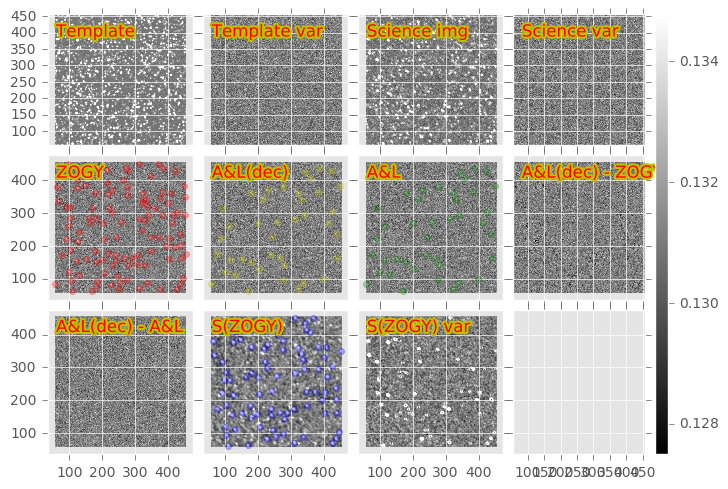

In [3]:
cx = cy = 256; sz = 200

_, _, grid = testObj3.doPlot(centroidCoord=[cx, cy, sz], include_Szogy=True);

def overlayPoints(grid, igrid, sources, cx, cy, sz, color='b'):
    def betw(x, a, b):
        return (x >= a) & (x <= b)

    src = dit.catalogToDF(sources)[['base_PeakCentroid_x',
             'base_PeakCentroid_y', 'base_PeakLikelihoodFlux_flag',
             'base_PeakLikelihoodFlux_flux', 'base_PeakLikelihoodFlux_fluxSigma',
             'base_PixelFlags_flag_bad']]
    xvals = xvalsTmp = src.base_PeakCentroid_x
    yvals = yvalsTmp = src.base_PeakCentroid_y
    xvals = xvals[betw(xvals, cx-sz, cx+sz) & betw(yvals, cy-sz, cy+sz)]
    yvals = yvals[betw(xvalsTmp, cx-sz, cx+sz) & betw(yvals, cy-sz, cy+sz)]
    grid[igrid].scatter(xvals, yvals, alpha=0.3, color=color)

overlayPoints(grid, 9, testResults3['result']['sources']['SZOGY'], cx, cy, sz, 'b')
overlayPoints(grid, 4, testResults3['result']['sources']['ZOGY'], cx, cy, sz, 'r')
overlayPoints(grid, 6, testResults3['result']['sources']['ALstack'], cx, cy, sz, 'g')
overlayPoints(grid, 5, testResults3['result']['sources']['ALstack_decorr'], cx, cy, sz, 'y')

A&L(dec): stats(mean=0.65881294, stdev=18.649027, min=-101.31941, max=115.49134)
ZOGY: stats(mean=0.098099436855395433, stdev=20.481723468217922, min=-100.46289118555612, max=195.71088644301577)
A&L(dec) - ZOGY: stats(mean=0.55815120774544746, stdev=22.11306554530179, min=-179.55517134466837, max=105.41952141550607)
A&L(dec) - A&L: stats(mean=-0.0065648272, stdev=0.8058033, min=-4.7008514, max=5.2426224)


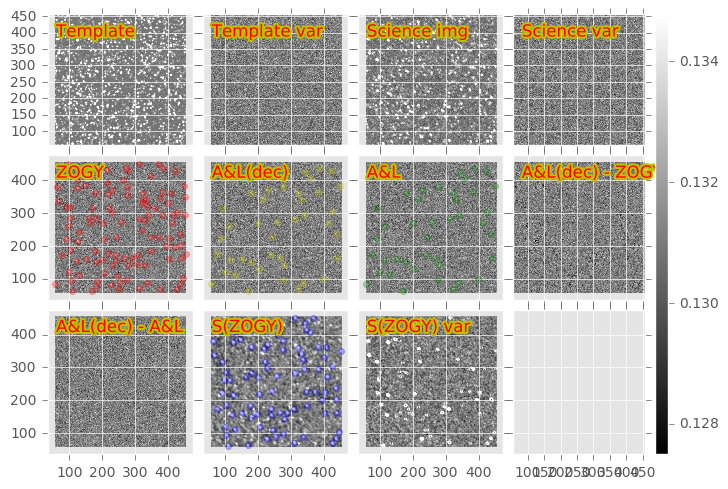

In [4]:
_, _, grid = testObj3.doPlot(centroidCoord=[cx, cy, sz], include_Szogy=True);
overlayPoints(grid, 9, testResults3['result']['sources']['SZOGY'], cx, cy, sz, 'b')
overlayPoints(grid, 4, testResults3['result']['sources']['ZOGY'], cx, cy, sz, 'r')
overlayPoints(grid, 6, testResults3['result']['sources']['ALstack'], cx, cy, sz, 'g')
overlayPoints(grid, 5, testResults3['result']['sources']['ALstack_decorr'], cx, cy, sz, 'y')

In [5]:
print dit.computeClippedImageStats(testObj3.im2.im)
print dit.computeClippedImageStats(testObj3.S_ZOGY.im)
print dit.computeClippedImageStats(testObj3.S_ZOGY.var)

stats(mean=7.4901025805417536, stdev=21.510033885495041, min=-79.0, max=1235.0)
stats(mean=-0.0092116711473479631, stdev=0.15844072949919011, min=-0.711628474687096, max=3.1810586897133919)
stats(mean=0.13109938233818758, stdev=0.00074878062493605169, min=0.12783072620596989, max=0.17172881286134128)


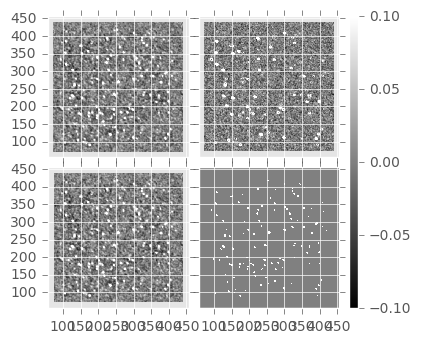

In [6]:
dit.plotImageGrid((testObj3.S_ZOGY.im, testObj3.S_ZOGY.var, 
                   testObj3.S_ZOGY.im / testObj3.S_ZOGY.var,
                   (testObj3.S_ZOGY.im / testObj3.S_ZOGY.var > 5.0) * 1.0),
                  extent=(cx-sz, cx+sz, cy-sz, cy+sz))

In [2]:
import diffimTests_OLD as ditOLD

In [3]:
def computeNormedPsfRms(psf1, psf2):
    psf1a = psf1.copy() / psf1.max()
    psf2a = psf2.copy() / psf2.max()
    weights = psf1a * psf2a   # instead of squaring either of them separately
    weights /= weights.mean()
    rms1weighted = np.sqrt(((psf1a - psf2a)**2. * weights).mean())
    return rms1weighted

In [4]:
sky = 300.

def runTest(n_sources=500, seed=66, n_varSources=50, flux=1500., scintillation=0., 
            returnObjs=False, printErrs=False):
    out = None
    try:
        # Make the "varying density" object to fit PSFs on
        testObj = ditOLD.DiffimTest(imSize=(512,512), sky=sky, psf1=[1.6,1.6], psf2=[1.8,2.2],
                             offset=[0,0], psf_yvary_factor=0., 
                             #varSourceChange=[1500., 1600., 1800., 2000., 2200., 2400., 2600., 2800.],
                             varFlux2=np.repeat(flux, n_varSources), variablesNearCenter=False,
                             theta1=0., theta2=-45., im2background=0., n_sources=n_sources, 
                             sourceFluxRange=(500,30000), scintillation=scintillation,
                             seed=seed, psfSize=21, avoidBorder=False)

        # Make the "constant density" object to actually run the tests on
        testObj2 = ditOLD.DiffimTest(imSize=(512,512), sky=sky, psf1=[1.6,1.6], psf2=[1.8,2.2],
                             offset=[0,0], psf_yvary_factor=0., 
                             #varSourceChange=[1500., 1600., 1800., 2000., 2200., 2400., 2600., 2800.],
                             varFlux2=np.repeat(flux, n_varSources), variablesNearCenter=False,
                             theta1=0., theta2=-45., im2background=0., n_sources=1000, 
                             sourceFluxRange=(500,30000), scintillation=scintillation,
                             seed=seed, psfSize=21, avoidBorder=False)

        if scintillation == 0:
            testObj.astrometricOffsets[0] = testObj.astrometricOffsets[1] = 0.
            testObj2.astrometricOffsets[0] = testObj2.astrometricOffsets[1] = 0.

        try:
            testRes1 = testObj2.runTest(zogyImageSpace=False)
        except Exception as e:
            if printErrs:
                print 'HERE1', e
            testRes1 = None
        
        try:
            actualPsf1 = testObj.im1.psf.copy() #dit.makePsf(21, [1.6, 1.6], offset=[0., 0.], theta=0.)
            im1 = testObj.im1.asAfwExposure()
            res1 = ditOLD.measurePsf(im1, detectThresh=5.0, measurePsfAlg='psfex')
            psf1 = ditOLD.afwPsfToArray(res1.psf, im1) #.computeImage()
            psf1a = psf1.copy() #/ np.abs(psf2.getArray()).sum()
            psf1anorm = psf1a[np.abs(psf1a)>=1e-3].sum()
            psf1a /= psf1anorm
            rms1 = np.sqrt(((psf1a - actualPsf1)**2.).mean()) #* 100.
            normedRms1 = computeNormedPsfRms(psf1a, actualPsf1)
            sh = ditOLD.arrayToAfwPsf(actualPsf1).computeShape()
            inputShape1 = [sh.getDeterminantRadius(), sh.getIxx(), sh.getIyy(), sh.getIxy()]
            sh = ditOLD.afwPsfToShape(res1.psf, im1)
            shape1 = [sh.getDeterminantRadius(), sh.getIxx(), sh.getIyy(), sh.getIxy()]
            moments1 = ditOLD.computeMoments(psf1)
        except Exception as e:
            if printErrs:
                print 'HERE2', e
            psf1 = rms1 = shape1 = moments1 = inputShape1 = normedRms1 = None

        try:
            actualPsf2 = testObj.im2.psf.copy() #dit.makePsf(21, [1.8, 2.2], offset=[0., 0.], theta=-45.)
            im2 = testObj.im2.asAfwExposure()
            res2 = ditOLD.measurePsf(im2, detectThresh=5.0, measurePsfAlg='psfex')
            psf2 = ditOLD.afwPsfToArray(res2.psf, im2) #.computeImage()
            psf2a = psf2.copy() #/ np.abs(psf2.getArray()).sum()
            psf2anorm = psf2a[np.abs(psf2a)>=1e-3].sum()
            psf2a /= psf2anorm
            rms2 = np.sqrt(((psf2a - actualPsf2)**2.).mean()) #* 100.
            normedRms2 = computeNormedPsfRms(psf2a, actualPsf2)
            sh = ditOLD.arrayToAfwPsf(actualPsf2).computeShape()
            inputShape2 = [sh.getDeterminantRadius(), sh.getIxx(), sh.getIyy(), sh.getIxy()]
            sh = ditOLD.afwPsfToShape(res2.psf, im2)
            shape2 = [sh.getDeterminantRadius(), sh.getIxx(), sh.getIyy(), sh.getIxy()]
            moments2 = ditOLD.computeMoments(psf2)
        except Exception as e:
            if printErrs:
                print 'HERE3', e
            psf2 = rms2 = shape2 = moments2 = inputShape2 = normedRms2 = None

        try:
            testObj2.reset()
            psf1b = psf1a.copy()
            psf1b[psf1b < 0] = 0
            psf1b[0:10,0:10] = psf1b[31:41,31:41] = 0
            psf1b /= psf1b.sum()
            psf2b = psf2a.copy()
            psf2b[psf2b < 0] = 0
            psf2b[0:10,0:10] = psf2b[31:41,31:41] = 0
            psf2b /= psf2b.sum()
            testObj2.im1.psf = psf1b
            testObj2.im2.psf = psf2b
            testRes2 = testObj2.runTest(zogyImageSpace=False)
        except Exception as e:
            if printErrs:
                print 'HERE4', e
            testRes2 = None

        out = {'psf1': psf1, 'psf2': psf2,
               'inputPsf1': actualPsf1, 'inputPsf2': actualPsf2,
               'rms1': rms1, 'rms2': rms2, 
               'shape1': shape1, 'shape2': shape2,
               'inputShape1': inputShape1, 'inputShape2': inputShape2,
               'moments1': moments1, 'moments2': moments2,
               'nSources': n_sources, 'seed': seed,
               'diffimResInputPsf': testRes1, 'diffimResMeasuredPsf': testRes2,
               'normedRms1': normedRms1, 'normedRms2': normedRms2}
        
        if returnObjs:
            out['obj1'] = testObj
            out['obj2'] = testObj2
    except Exception as e:
        if printErrs:
            print 'HERE5', e
        pass
    return out

In [5]:
tmp = runTest(n_sources=50, seed=1, returnObjs=True, printErrs=True);
#del tmp['inputPsf1'], tmp['inputPsf2'], tmp['psf1'], tmp['psf2']
tmp['diffimResInputPsf']

HERE2 No objects passed our cuts for consideration as psf stars
HERE3 No objects passed our cuts for consideration as psf stars
HERE4 local variable 'psf1a' referenced before assignment


{'ALstack': {'FN': 17, 'FP': 2, 'TP': 33},
 'ALstack_noDecorr': {'FN': 14, 'FP': 2, 'TP': 36},
 'SZOGY': {'FN': 11, 'FP': 3, 'TP': 39},
 'ZOGY': {'FN': 8, 'FP': 0, 'TP': 42}}

In [6]:
tmp2 = runTest(n_sources=4500, seed=2, returnObjs=True, printErrs=True);

In [ ]:
print tmp2['diffimResInputPsf']
print tmp2['diffimResMeasuredPsf']

{'ZOGY': {'FP': 2, 'FN': 11, 'TP': 39}, 'ALstack': {'FP': 1, 'FN': 16, 'TP': 34}, 'SZOGY': {'FP': 7, 'FN': 16, 'TP': 34}, 'ALstack_noDecorr': {'FP': 1, 'FN': 14, 'TP': 36}}
{'ZOGY': {'FP': 6, 'FN': 13, 'TP': 37}, 'ALstack': {'FP': 1, 'FN': 16, 'TP': 34}, 'SZOGY': {'FP': 4, 'FN': 13, 'TP': 37}, 'ALstack_noDecorr': {'FP': 1, 'FN': 13, 'TP': 37}}


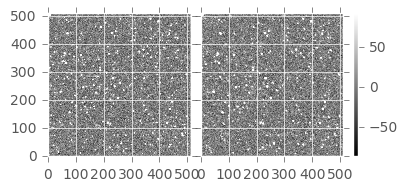

In [71]:
dit.plotImageGrid((tmp2['obj2'].im1.im, tmp2['obj2'].im2.im))

In [ ]:
res1 = dit.tasks.doMeasurePsf(tmp2['obj1'].im1.asAfwExposure(), detectThresh=5.0, measurePsfAlg='psfex')
res2 = dit.tasks.doMeasurePsf(tmp2['obj1'].im2.asAfwExposure(), detectThresh=5.0, measurePsfAlg='psfex')

res1old = ditOLD.measurePsf(tmp2['obj1'].im1.asAfwExposure(), detectThresh=5.0, measurePsfAlg='psfex')
res2old = ditOLD.measurePsf(tmp2['obj1'].im2.asAfwExposure(), detectThresh=5.0, measurePsfAlg='psfex')

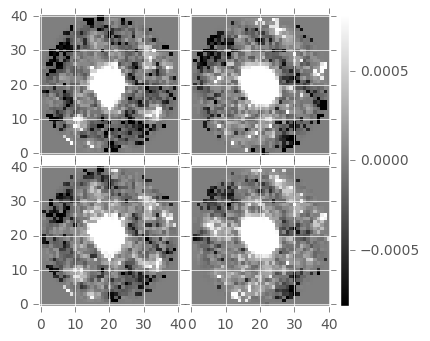

In [10]:
psf1 = dit.afw.afwPsfToArray(res1.psf, tmp2['obj1'].im1.asAfwExposure())
psf2 = dit.afw.afwPsfToArray(res2.psf, tmp2['obj1'].im2.asAfwExposure())

psf1old = dit.afw.afwPsfToArray(res1old.psf, tmp2['obj1'].im1.asAfwExposure())
psf2old = dit.afw.afwPsfToArray(res2old.psf, tmp2['obj1'].im1.asAfwExposure())

dit.plotImageGrid((psf1, psf2, psf1old, psf2old))

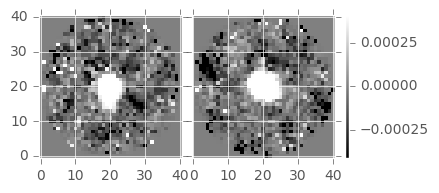

In [11]:
dit.plotImageGrid((psf1-psf1old, psf2-psf2old))

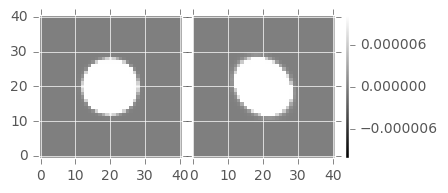

In [12]:
inpPsf1 = tmp2['inputPsf1']
inpPsf2 = tmp2['inputPsf2']
dit.plotImageGrid((inpPsf1, inpPsf2))

In [13]:
print computeNormedPsfRms(inpPsf1, psf1)
print computeNormedPsfRms(inpPsf1, psf1old)

print computeNormedPsfRms(inpPsf2, psf2)
print computeNormedPsfRms(inpPsf2, psf2old)

0.00604358374227
0.00522040783388
0.00494228413871
0.00556874640499


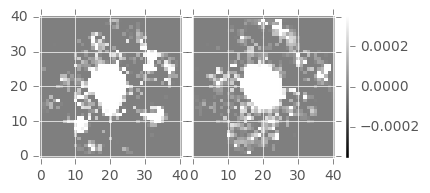

In [14]:
psf1b = psf1.copy()
psf1b[psf1b < 0] = 0
psf1b[0:10,0:10] = psf1b[31:41,31:41] = 0
#psf1b = recenterPsf(psf1b)
psf1b /= psf1b.sum()

psf2b = psf2.copy()
psf2b[psf2b < 0] = 0
psf2b[0:10,0:10] = psf2b[31:41,31:41] = 0
#psf2b = recenterPsf(psf2b)
psf2b /= psf2b.sum()

dit.plotImageGrid((psf1b, psf2b))

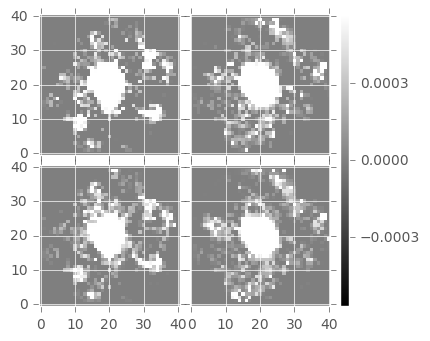

In [15]:
dit.plotImageGrid((psf1b, psf2b, tmp2['obj2'].im1.psf, tmp2['obj2'].im2.psf))

0.0 0.057845626539 1.0
0.0 0.056796375489 1.0
(ixx=2.58063403858, iyy=2.62460328865, ixy=-0.0180079045191)
(ixx=2.58460579336, iyy=2.60402185567, ixy=-0.0137613246451)


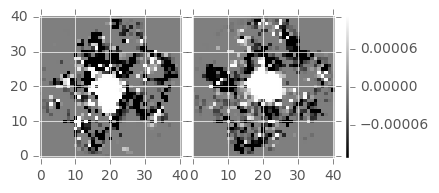

In [16]:
print psf1b.min(), psf1b.max(), psf1b.sum()
print tmp2['obj2'].im1.psf.min(), tmp2['obj2'].im1.psf.max(), tmp2['obj2'].im1.psf.sum()
print dit.afw.arrayToAfwPsf(psf1b).computeShape()
print dit.afw.arrayToAfwPsf(tmp2['obj2'].im1.psf).computeShape()
dit.plotImageGrid((psf1b-tmp2['obj2'].im1.psf, psf2b-tmp2['obj2'].im2.psf))

In [17]:
print computeNormedPsfRms(inpPsf1, psf1b)
print computeNormedPsfRms(inpPsf1, psf1)
print computeNormedPsfRms(inpPsf1, psf1old)
print computeNormedPsfRms(inpPsf1, tmp2['obj2'].im1.psf)
print computeNormedPsfRms(inpPsf1, tmp2['psf1'])

0.00604358226499
0.00604358374227
0.00522040783388
0.00522040631581
0.00522040783388


In [18]:
im1 = tmp2['obj1'].im1.asAfwExposure()
res1old2 = ditOLD.measurePsf(im1, detectThresh=5.0, measurePsfAlg='psfex')
psf1old2 = ditOLD.afwPsfToArray(res1old2.psf, im1) #.computeImage()
print computeNormedPsfRms(inpPsf1, psf1old2)

0.00522040783388


In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import diffimTests as dit

import warnings
warnings.filterwarnings('ignore')

In [2]:
n_runs = 10
ns = np.append(np.insert(np.arange(500, 5001, 250), 0, [50, 100, 250]), [7500, 10000, 15000])
testResults1 = dit.multi.runMultiDiffimTests(varSourceFlux=620., 
                                             n_varSources=50, nStaticSources=ns,
                                             #templateNoNoise=True, 
                                             #skyLimited=True,
                                             sourceFluxRange=(600., 30000.),
                                             sky=[30., 300.],
                                             avoidAllOverlaps=0.,
                                             n_runs=n_runs, remeasurePsfs=[False, False], zogyImageSpace=True)

RUNNING: 250
CORES: 4


[Parallel(n_jobs=4)]: Done  17 tasks      | elapsed:   44.8s
[Parallel(n_jobs=4)]: Done  90 tasks      | elapsed:  4.0min


Weights sum to zero, can't be normalized
Weights sum to zero, can't be normalized
Weights sum to zero, can't be normalized
Weights sum to zero, can't be normalized
Weights sum to zero, can't be normalized
Weights sum to zero, can't be normalized
Weights sum to zero, can't be normalized
Weights sum to zero, can't be normalized
Weights sum to zero, can't be normalized
Weights sum to zero, can't be normalized
Weights sum to zero, can't be normalized
Weights sum to zero, can't be normalized
Weights sum to zero, can't be normalized
Weights sum to zero, can't be normalized
Weights sum to zero, can't be normalized
Weights sum to zero, can't be normalized
Weights sum to zero, can't be normalized
Weights sum to zero, can't be normalized
Weights sum to zero, can't be normalized
Weights sum to zero, can't be normalized
Weights sum to zero, can't be normalized


[Parallel(n_jobs=4)]: Done 213 tasks      | elapsed:  9.9min


Weights sum to zero, can't be normalized
Weights sum to zero, can't be normalized
Weights sum to zero, can't be normalized
Weights sum to zero, can't be normalized
Weights sum to zero, can't be normalized
ERROR RUNNING SEED: 75
No matches provided.


[Parallel(n_jobs=4)]: Done 250 out of 250 | elapsed: 12.1min finished


250 250


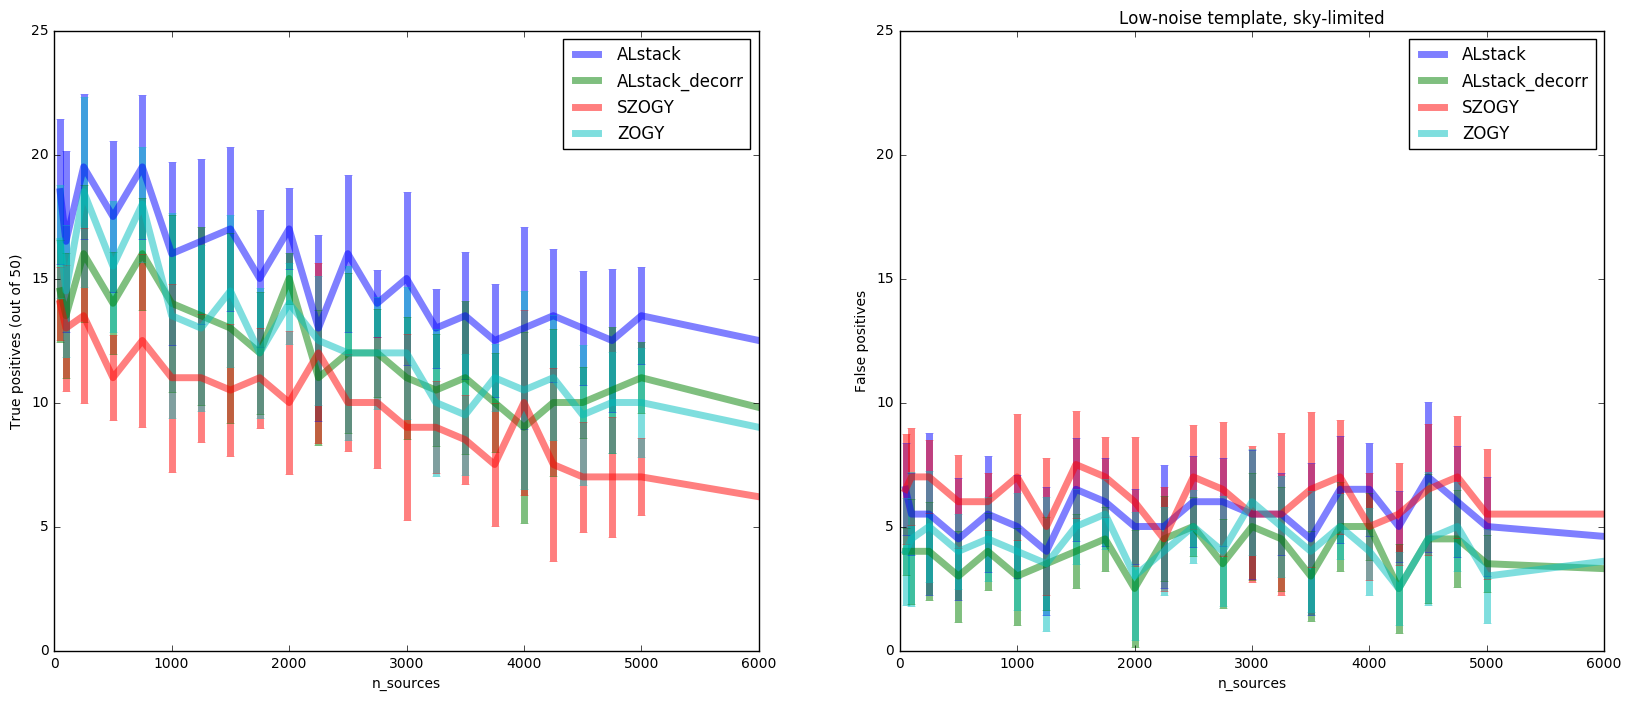

In [3]:
import pandas as pd
methods = ['ALstack', 'ZOGY', 'SZOGY', 'ALstack_decorr']

tr1 = [tr for tr in testResults1 if tr['result'] is not None]
print len(testResults1), len(tr1)

TP1 = []; FP1 = []; FN1 = []
for i, tr in enumerate(tr1):    
    FN = {key: tr['result'][key]['FN'] for key in methods}
    FN['n_sources'] = tr['n_sources']
    FN1.append(pd.DataFrame(FN, index=[0]))

    TP = {key: tr['result'][key]['TP'] for key in methods}
    TP['n_sources'] = tr['n_sources']
    TP1.append(pd.DataFrame(TP, index=[0]))

    FP = {key: tr['result'][key]['FP'] for key in methods}
    FP['n_sources'] = tr['n_sources']
    FP1.append(pd.DataFrame(FP, index=[0]))

FN1mn = pd.concat(FN1, axis=0).groupby('n_sources').median()
TP1mn = pd.concat(TP1, axis=0).groupby('n_sources').median()
FP1mn = pd.concat(FP1, axis=0).groupby('n_sources').median()

FN1err = pd.concat(FN1, axis=0).groupby('n_sources').std()
TP1err = pd.concat(TP1, axis=0).groupby('n_sources').std()
FP1err = pd.concat(FP1, axis=0).groupby('n_sources').std()

plt.subplots(1, 2, figsize=(20, 8))
ax = plt.subplot(121)
#TP1mn.drop('SZOGY', 1).reset_index().plot(x='n_sources', yerr=TP1err, alpha=0.5, lw=5, ax=ax)
TP1mn.reset_index().plot(x='n_sources', yerr=TP1err, alpha=0.5, lw=5, ax=ax)
ax.set_ylabel('True positives (out of 50)')
ax.set_xlim(0, 6000)
ax.set_ylim(0, 25)
ax = plt.subplot(122)    
#FP1mn.drop('SZOGY', 1).reset_index().plot(x='n_sources', yerr=FP1err, alpha=0.5, lw=5, ax=ax)
FP1mn.reset_index().plot(x='n_sources', yerr=FP1err, alpha=0.5, lw=5, ax=ax)
ax.set_ylabel('False positives')
ax.set_title('Low-noise template, sky-limited')
ax.set_xlim(0, 6000)
ax.set_ylim(0, 25);

In [4]:
n_runs = 10
ns = np.append(np.insert(np.arange(500, 5001, 250), 0, [50, 100, 250]), [7500, 10000, 15000])
testResults2 = dit.multi.runMultiDiffimTests(varSourceFlux=620., 
                                             n_varSources=50, nStaticSources=ns,
                                             #templateNoNoise=True, 
                                             #skyLimited=True,
                                             sky=[30., 300.],
                                             avoidAllOverlaps=0.,
                                             n_runs=n_runs, remeasurePsfs=[True, True], zogyImageSpace=True)

RUNNING: 250
CORES: 4
HERE1: No objects passed our cuts for consideration as psf stars
HERE1: No objects passed our cuts for consideration as psf stars

  File "src/PsfexPsf.cc", line 192, in virtual std::shared_ptr<afw::detection::Psf::Image> lsst::meas::extensions::psfex::PsfexPsf::_doComputeImage(const afw::geom::Point2D &, const afw::image::Color &, const afw::geom::Point2D &) const
    Only spatial variation (ndim == 2) is supported; saw 0 {0}
lsst::pex::exceptions::InvalidParameterError: 'Only spatial variation (ndim == 2) is supported; saw 0'

HERE1: 'NoneType' object has no attribute 'shape'

  File "src/PsfexPsf.cc", line 192, in virtual std::shared_ptr<afw::detection::Psf::Image> lsst::meas::extensions::psfex::PsfexPsf::_doComputeImage(const afw::geom::Point2D &, const afw::image::Color &, const afw::geom::Point2D &) const
    Only spatial variation (ndim == 2) is supported; saw 0 {0}
lsst::pex::exceptions::InvalidParameterError: 'Only spatial variation (ndim == 2) is support

[Parallel(n_jobs=4)]: Done  17 tasks      | elapsed:   50.3s



  File "src/PsfexPsf.cc", line 192, in virtual std::shared_ptr<afw::detection::Psf::Image> lsst::meas::extensions::psfex::PsfexPsf::_doComputeImage(const afw::geom::Point2D &, const afw::image::Color &, const afw::geom::Point2D &) const
    Only spatial variation (ndim == 2) is supported; saw 0 {0}
lsst::pex::exceptions::InvalidParameterError: 'Only spatial variation (ndim == 2) is supported; saw 0'

HERE1: 'NoneType' object has no attribute 'shape'

  File "src/PsfexPsf.cc", line 192, in virtual std::shared_ptr<afw::detection::Psf::Image> lsst::meas::extensions::psfex::PsfexPsf::_doComputeImage(const afw::geom::Point2D &, const afw::image::Color &, const afw::geom::Point2D &) const
    Only spatial variation (ndim == 2) is supported; saw 0 {0}
lsst::pex::exceptions::InvalidParameterError: 'Only spatial variation (ndim == 2) is supported; saw 0'

HERE1: 'NoneType' object has no attribute 'shape'

  File "src/PsfexPsf.cc", line 192, in virtual std::shared_ptr<afw::detection::Psf::Image

[Parallel(n_jobs=4)]: Done  90 tasks      | elapsed:  7.3min


ERROR RUNNING SEED: 73
No matches provided.
ERROR RUNNING SEED: 69
No matches provided.
ERROR RUNNING SEED: 70
No matches provided.
Weights sum to zero, can't be normalized
ERROR RUNNING SEED: 69
No matches provided.
ERROR RUNNING SEED: 66
No matches provided.
ERROR RUNNING SEED: 68
No matches provided.
ERROR RUNNING SEED: 71
No matches provided.
Weights sum to zero, can't be normalized
ERROR RUNNING SEED: 66
No matches provided.
ERROR RUNNING SEED: 71
No matches provided.
ERROR RUNNING SEED: 72
No matches provided.
ERROR RUNNING SEED: 68
No matches provided.
ERROR RUNNING SEED: 69
No matches provided.


[Parallel(n_jobs=4)]: Done 213 tasks      | elapsed: 27.9min


Weights sum to zero, can't be normalized
Weights sum to zero, can't be normalized
ERROR RUNNING SEED: 68
No matches provided.
ERROR RUNNING SEED: 70
No matches provided.
ERROR RUNNING SEED: 71
No matches provided.
ERROR RUNNING SEED: 72
No matches provided.
ERROR RUNNING SEED: 75
No matches provided.
ERROR RUNNING SEED: 66
No matches provided.
ERROR RUNNING SEED: 67
No matches provided.
ERROR RUNNING SEED: 68
No matches provided.
Weights sum to zero, can't be normalized
ERROR RUNNING SEED: 69
No matches provided.
ERROR RUNNING SEED: 72
No matches provided.
ERROR RUNNING SEED: 73
No matches provided.
ERROR RUNNING SEED: 74
No matches provided.
Weights sum to zero, can't be normalized
Weights sum to zero, can't be normalized
ERROR RUNNING SEED: 66
No matches provided.
ERROR RUNNING SEED: 67
No matches provided.
ERROR RUNNING SEED: 68
No matches provided.
ERROR RUNNING SEED: 69
No matches provided.
Weights sum to zero, can't be normalized
Weights sum to zero, can't be normalized
ERROR RUN

[Parallel(n_jobs=4)]: Done 250 out of 250 | elapsed: 34.4min finished


250 250


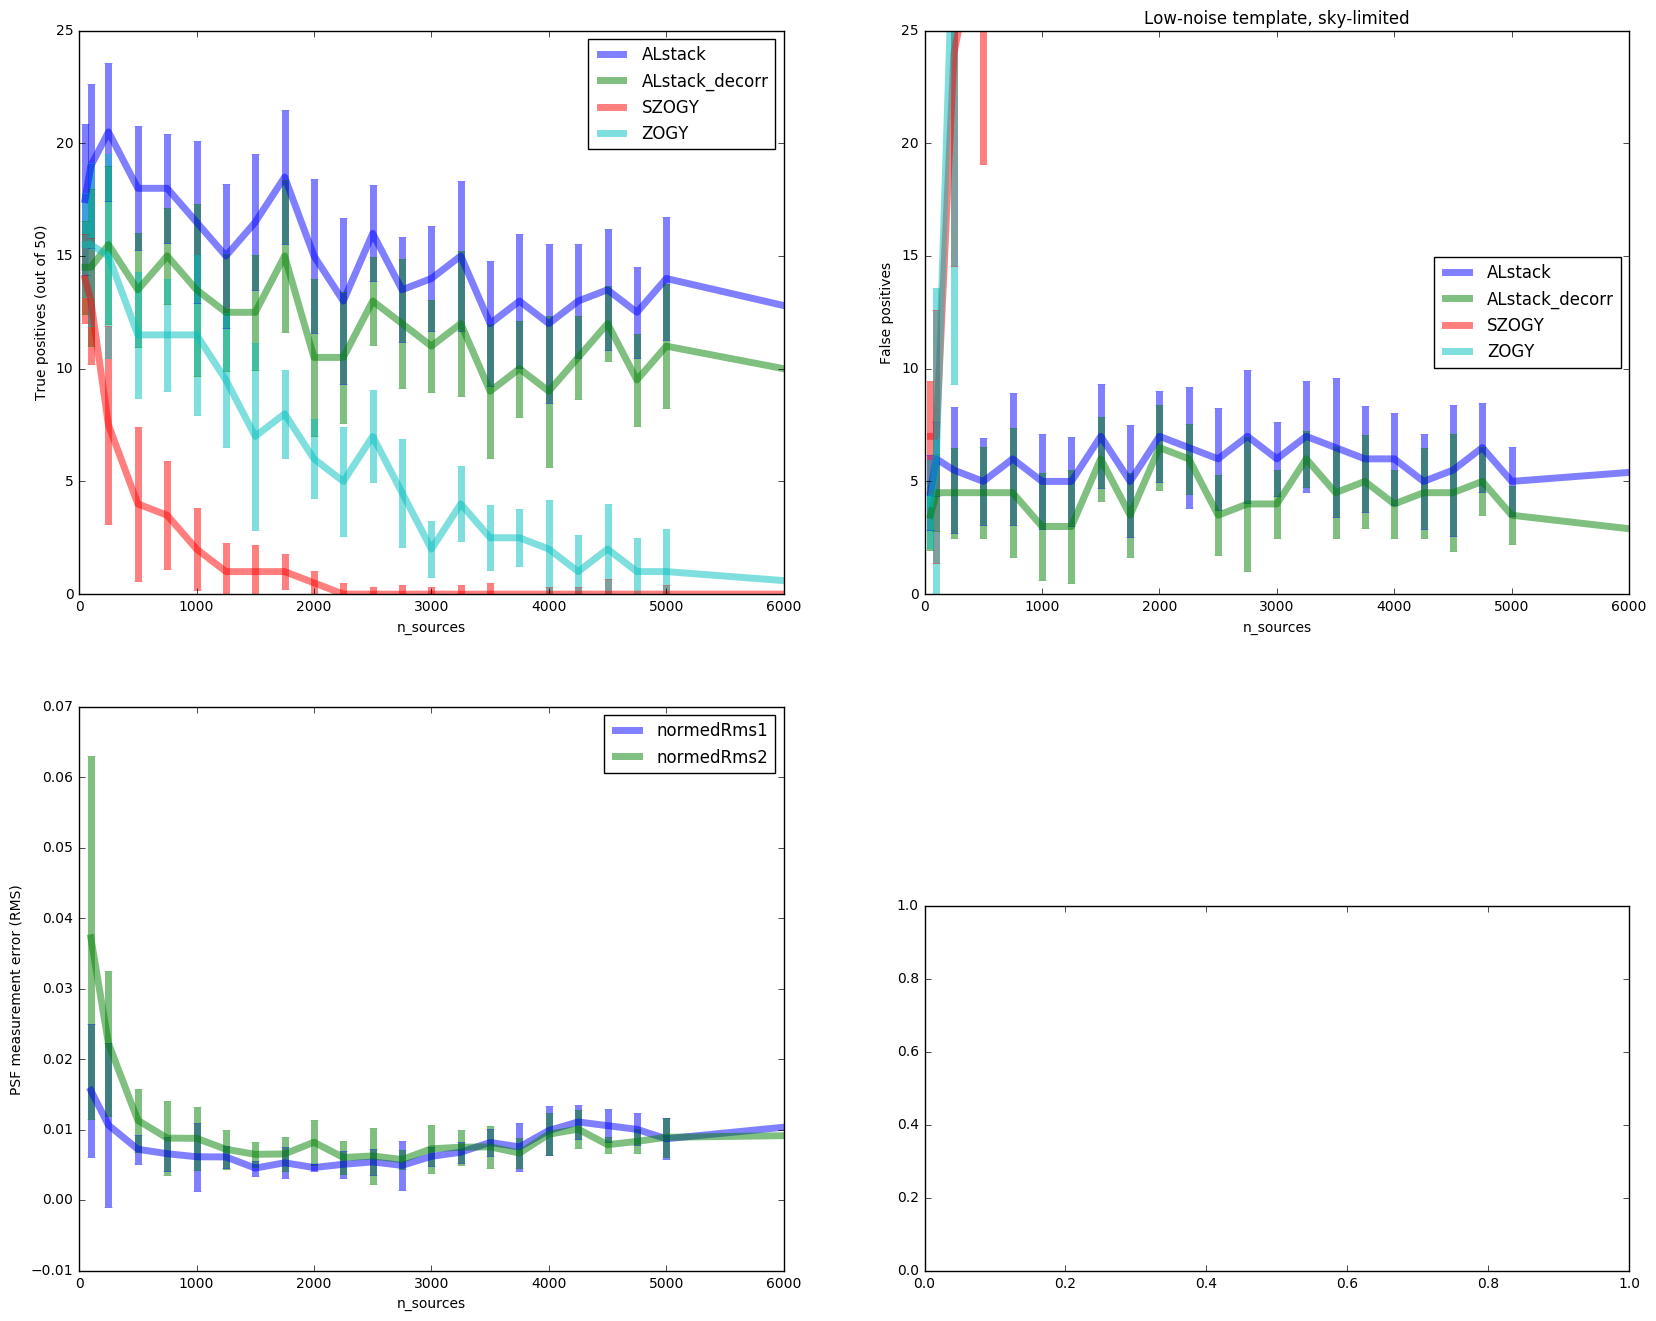

In [5]:
import pandas as pd
methods = ['ALstack', 'ZOGY', 'SZOGY', 'ALstack_decorr']

tr2 = [tr for tr in testResults2 if tr['result'] is not None]
print len(testResults2), len(tr2)

TP1 = []; FP1 = []; FN1 = []
for i, tr in enumerate(tr2):    
    rms1 = tr['psfInfo']['normedRms1']
    if rms1 is None:
        rms1 = np.nan
    rms2 = tr['psfInfo']['normedRms2']
    if rms2 is None:
        rms2 = np.nan

    TP = {key: tr['result'][key]['TP'] for key in methods}
    TP['n_sources'] = tr['n_sources']
    TP['normedRms1'] = rms1
    TP['normedRms2'] = rms2
    TP1.append(pd.DataFrame(TP, index=[0]))

    FN = {key: tr['result'][key]['FN'] for key in methods}
    FN['n_sources'] = tr['n_sources']
    FN1.append(pd.DataFrame(FN, index=[0]))

    FP = {key: tr['result'][key]['FP'] for key in methods}
    FP['n_sources'] = tr['n_sources']
    FP1.append(pd.DataFrame(FP, index=[0]))

FN1mn = pd.concat(FN1, axis=0).groupby('n_sources').median()
TP1mn = pd.concat(TP1, axis=0).groupby('n_sources').median()
FP1mn = pd.concat(FP1, axis=0).groupby('n_sources').median()

FN1err = pd.concat(FN1, axis=0).groupby('n_sources').std()
TP1err = pd.concat(TP1, axis=0).groupby('n_sources').std()
FP1err = pd.concat(FP1, axis=0).groupby('n_sources').std()

plt.subplots(3, 2, figsize=(20, 16))
ax = plt.subplot(221)    
TP1mn.drop(['normedRms1','normedRms2'], 1).reset_index().plot(x='n_sources', 
                                               yerr=TP1err.drop(['normedRms1','normedRms2'], 1), 
                                               alpha=0.5, lw=5, ax=ax)
ax.set_ylabel('True positives (out of 50)')
ax.set_xlim(0, 6000)
ax.set_ylim(0, 25)
ax = plt.subplot(222)    
FP1mn.reset_index().plot(x='n_sources', yerr=FP1err, alpha=0.5, lw=5, ax=ax)
ax.set_ylabel('False positives')
ax.set_title('Low-noise template, sky-limited')
ax.set_xlim(0, 6000)
ax.set_ylim(0, 25)

ax = plt.subplot(223)    
TP1mn[['normedRms1', 'normedRms2']].reset_index().plot(x='n_sources', 
                                                       yerr=TP1err[['normedRms1', 'normedRms2']],
                                                       alpha=0.5, lw=5, ax=ax)
ax.set_xlim(0, 6000)
ax.set_ylabel('PSF measurement error (RMS)')

In [6]:
n_runs = 10
ns = np.append(np.insert(np.arange(500, 5001, 250), 0, [50, 100, 250]), [7500, 10000, 15000])
testResults2a = dit.multi.runMultiDiffimTests(varSourceFlux=620., 
                                             n_varSources=50, nStaticSources=ns,
                                             #templateNoNoise=True, 
                                             #skyLimited=True,
                                             sky=[30., 300.],
                                             avoidAllOverlaps=0.,
                                             n_runs=n_runs, remeasurePsfs=[True, True], zogyImageSpace=False)

RUNNING: 250
CORES: 4
HERE1: No objects passed our cuts for consideration as psf stars
HERE1: No objects passed our cuts for consideration as psf stars

  File "src/PsfexPsf.cc", line 192, in virtual std::shared_ptr<afw::detection::Psf::Image> lsst::meas::extensions::psfex::PsfexPsf::_doComputeImage(const afw::geom::Point2D &, const afw::image::Color &, const afw::geom::Point2D &) const
    Only spatial variation (ndim == 2) is supported; saw 0 {0}
lsst::pex::exceptions::InvalidParameterError: 'Only spatial variation (ndim == 2) is supported; saw 0'

HERE1: 'NoneType' object has no attribute 'shape'

  File "src/PsfexPsf.cc", line 192, in virtual std::shared_ptr<afw::detection::Psf::Image> lsst::meas::extensions::psfex::PsfexPsf::_doComputeImage(const afw::geom::Point2D &, const afw::image::Color &, const afw::geom::Point2D &) const
    Only spatial variation (ndim == 2) is supported; saw 0 {0}
lsst::pex::exceptions::InvalidParameterError: 'Only spatial variation (ndim == 2) is support

[Parallel(n_jobs=4)]: Done  17 tasks      | elapsed:   39.9s



  File "src/PsfexPsf.cc", line 192, in virtual std::shared_ptr<afw::detection::Psf::Image> lsst::meas::extensions::psfex::PsfexPsf::_doComputeImage(const afw::geom::Point2D &, const afw::image::Color &, const afw::geom::Point2D &) const
    Only spatial variation (ndim == 2) is supported; saw 0 {0}
lsst::pex::exceptions::InvalidParameterError: 'Only spatial variation (ndim == 2) is supported; saw 0'

HERE1: 'NoneType' object has no attribute 'shape'

  File "src/PsfexPsf.cc", line 192, in virtual std::shared_ptr<afw::detection::Psf::Image> lsst::meas::extensions::psfex::PsfexPsf::_doComputeImage(const afw::geom::Point2D &, const afw::image::Color &, const afw::geom::Point2D &) const
    Only spatial variation (ndim == 2) is supported; saw 0 {0}
lsst::pex::exceptions::InvalidParameterError: 'Only spatial variation (ndim == 2) is supported; saw 0'

HERE1: 'NoneType' object has no attribute 'shape'

  File "src/PsfexPsf.cc", line 192, in virtual std::shared_ptr<afw::detection::Psf::Image

[Parallel(n_jobs=4)]: Done  90 tasks      | elapsed:  6.1min


Weights sum to zero, can't be normalized
Weights sum to zero, can't be normalized


[Parallel(n_jobs=4)]: Done 213 tasks      | elapsed: 20.9min


Weights sum to zero, can't be normalized
Weights sum to zero, can't be normalized
Weights sum to zero, can't be normalized
Weights sum to zero, can't be normalized
Weights sum to zero, can't be normalized
ERROR RUNNING SEED: 69
No matches provided.
Weights sum to zero, can't be normalized
ERROR RUNNING SEED: 71
No matches provided.
Weights sum to zero, can't be normalized
ERROR RUNNING SEED: 72
No matches provided.
ERROR RUNNING SEED: 73
No matches provided.


[Parallel(n_jobs=4)]: Done 250 out of 250 | elapsed: 27.3min finished


250 250


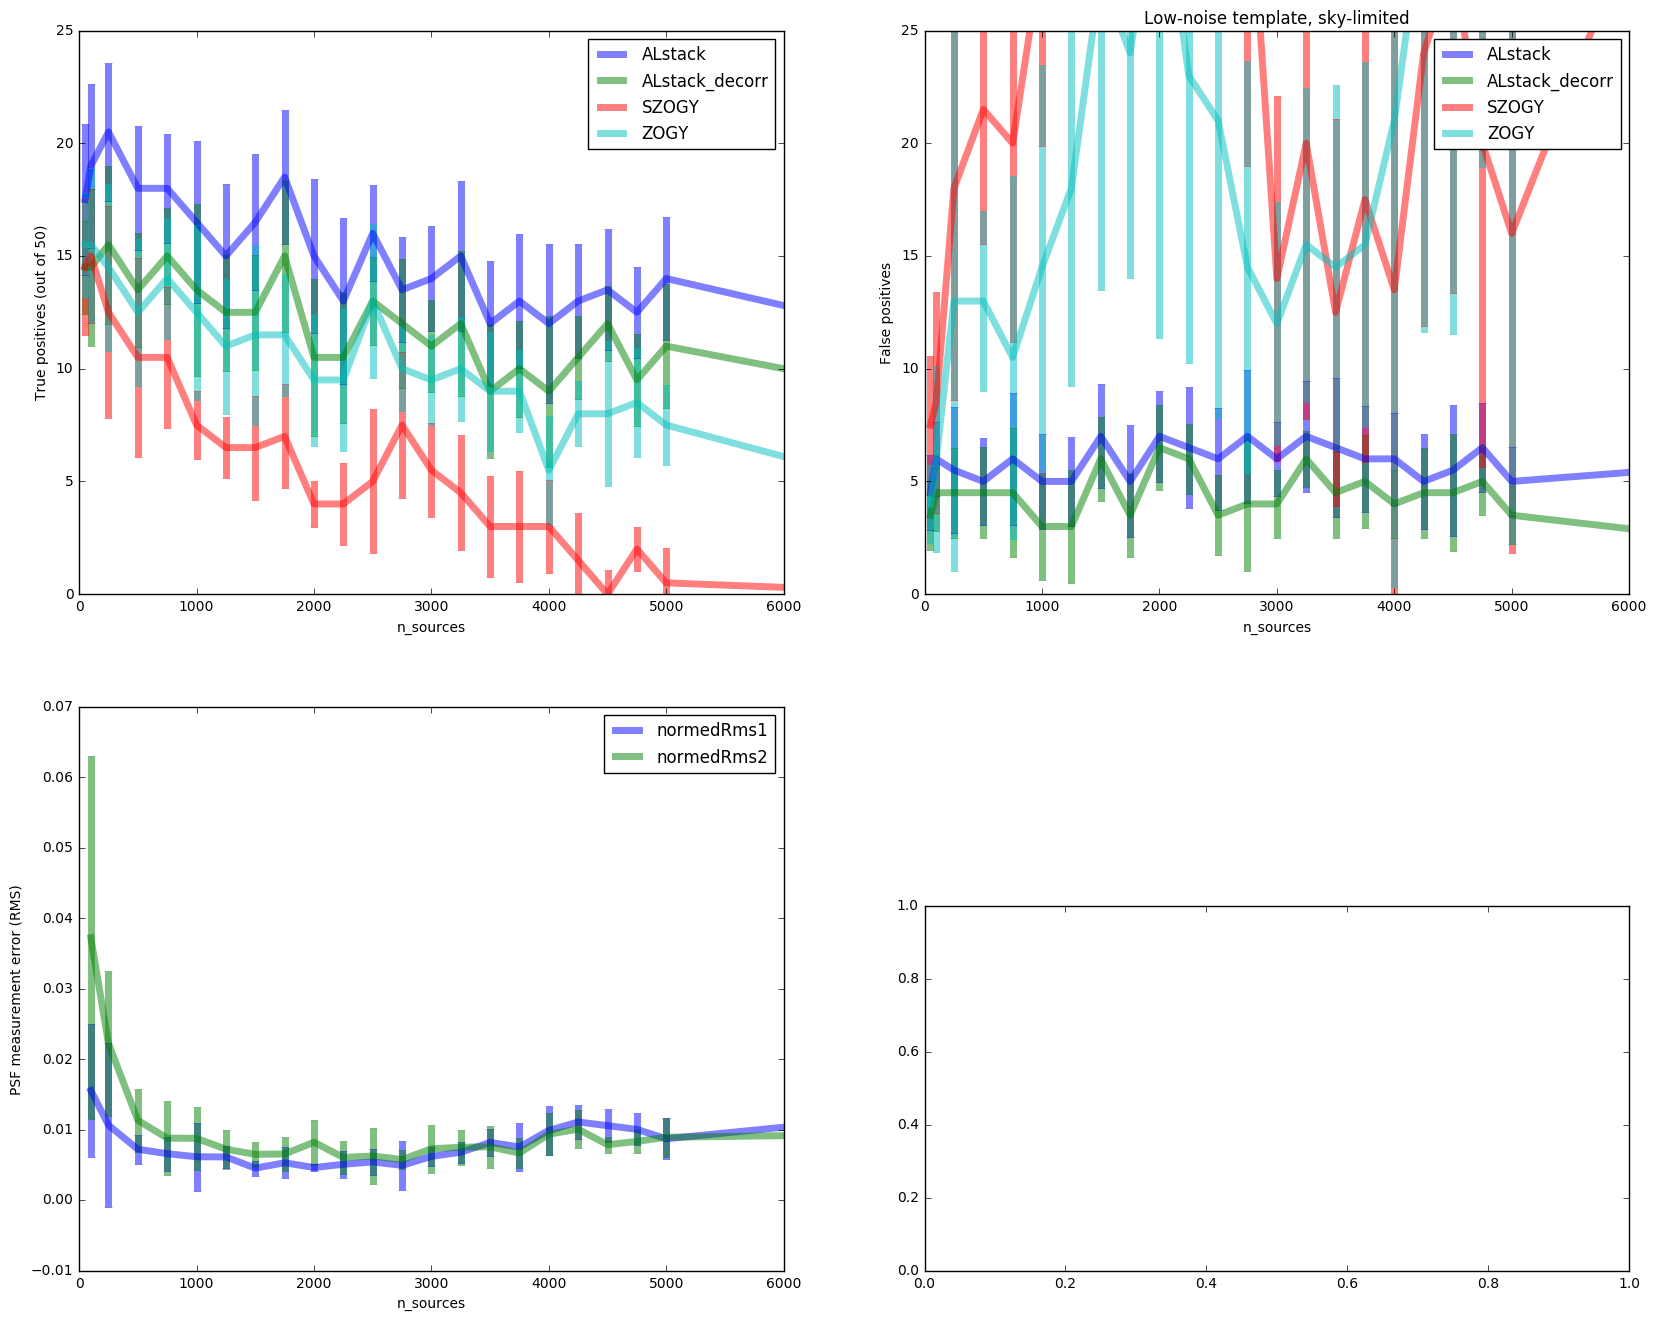

In [7]:
import pandas as pd
methods = ['ALstack', 'ZOGY', 'SZOGY', 'ALstack_decorr']

tr2 = [tr for tr in testResults2a if tr['result'] is not None]
print len(testResults2), len(tr2)

TP1 = []; FP1 = []; FN1 = []
for i, tr in enumerate(tr2):    
    rms1 = tr['psfInfo']['normedRms1']
    if rms1 is None:
        rms1 = np.nan
    rms2 = tr['psfInfo']['normedRms2']
    if rms2 is None:
        rms2 = np.nan

    TP = {key: tr['result'][key]['TP'] for key in methods}
    TP['n_sources'] = tr['n_sources']
    TP['normedRms1'] = rms1
    TP['normedRms2'] = rms2
    TP1.append(pd.DataFrame(TP, index=[0]))

    FN = {key: tr['result'][key]['FN'] for key in methods}
    FN['n_sources'] = tr['n_sources']
    FN1.append(pd.DataFrame(FN, index=[0]))

    FP = {key: tr['result'][key]['FP'] for key in methods}
    FP['n_sources'] = tr['n_sources']
    FP1.append(pd.DataFrame(FP, index=[0]))

FN1mn = pd.concat(FN1, axis=0).groupby('n_sources').median()
TP1mn = pd.concat(TP1, axis=0).groupby('n_sources').median()
FP1mn = pd.concat(FP1, axis=0).groupby('n_sources').median()

FN1err = pd.concat(FN1, axis=0).groupby('n_sources').std()
TP1err = pd.concat(TP1, axis=0).groupby('n_sources').std()
FP1err = pd.concat(FP1, axis=0).groupby('n_sources').std()

plt.subplots(3, 2, figsize=(20, 16))
ax = plt.subplot(221)    
TP1mn.drop(['normedRms1','normedRms2'], 1).reset_index().plot(x='n_sources', 
                                               yerr=TP1err.drop(['normedRms1','normedRms2'], 1), 
                                               alpha=0.5, lw=5, ax=ax)
ax.set_ylabel('True positives (out of 50)')
ax.set_xlim(0, 6000)
ax.set_ylim(0, 25)
ax = plt.subplot(222)    
FP1mn.reset_index().plot(x='n_sources', yerr=FP1err, alpha=0.5, lw=5, ax=ax)
ax.set_ylabel('False positives')
ax.set_title('Low-noise template, sky-limited')
ax.set_xlim(0, 6000)
ax.set_ylim(0, 25)

ax = plt.subplot(223)    
TP1mn[['normedRms1', 'normedRms2']].reset_index().plot(x='n_sources', 
                                                       yerr=TP1err[['normedRms1', 'normedRms2']],
                                                       alpha=0.5, lw=5, ax=ax)
ax.set_xlim(0, 6000)
ax.set_ylabel('PSF measurement error (RMS)')

In [8]:
import diffimTests_OLD_multi as multiOLD

n_runs = 10
ns = np.append(np.insert(np.arange(500, 5001, 250), 0, [50, 100, 250]), [7500, 10000, 15000])
testResults3 = multiOLD.runMultiDiffimTests(varSourceFlux=620., 
                                             n_varSources=50, nStaticSources=ns,
                                             #templateNoNoise=True, 
                                             #skyLimited=True,
                                             sky=[30., 300.],
                                             avoidAllOverlaps=0.,
                                             n_runs=n_runs, remeasurePsfs=[True, True], zogyImageSpace=True)

RUNNING: 250
CORES: 4
HERE1: No objects passed our cuts for consideration as psf stars
HERE1: No objects passed our cuts for consideration as psf stars

  File "src/PsfexPsf.cc", line 192, in virtual std::shared_ptr<afw::detection::Psf::Image> lsst::meas::extensions::psfex::PsfexPsf::_doComputeImage(const afw::geom::Point2D &, const afw::image::Color &, const afw::geom::Point2D &) const
    Only spatial variation (ndim == 2) is supported; saw 0 {0}
lsst::pex::exceptions::InvalidParameterError: 'Only spatial variation (ndim == 2) is supported; saw 0'

HERE1: 'NoneType' object has no attribute 'shape'

  File "src/PsfexPsf.cc", line 192, in virtual std::shared_ptr<afw::detection::Psf::Image> lsst::meas::extensions::psfex::PsfexPsf::_doComputeImage(const afw::geom::Point2D &, const afw::image::Color &, const afw::geom::Point2D &) const
    Only spatial variation (ndim == 2) is supported; saw 0 {0}
lsst::pex::exceptions::InvalidParameterError: 'Only spatial variation (ndim == 2) is support

[Parallel(n_jobs=4)]: Done  17 tasks      | elapsed:   48.6s



  File "src/PsfexPsf.cc", line 192, in virtual std::shared_ptr<afw::detection::Psf::Image> lsst::meas::extensions::psfex::PsfexPsf::_doComputeImage(const afw::geom::Point2D &, const afw::image::Color &, const afw::geom::Point2D &) const
    Only spatial variation (ndim == 2) is supported; saw 0 {0}
lsst::pex::exceptions::InvalidParameterError: 'Only spatial variation (ndim == 2) is supported; saw 0'

HERE1: 'NoneType' object has no attribute 'shape'

  File "src/PsfexPsf.cc", line 192, in virtual std::shared_ptr<afw::detection::Psf::Image> lsst::meas::extensions::psfex::PsfexPsf::_doComputeImage(const afw::geom::Point2D &, const afw::image::Color &, const afw::geom::Point2D &) const
    Only spatial variation (ndim == 2) is supported; saw 0 {0}
lsst::pex::exceptions::InvalidParameterError: 'Only spatial variation (ndim == 2) is supported; saw 0'

HERE1: 'NoneType' object has no attribute 'shape'

  File "src/PsfexPsf.cc", line 192, in virtual std::shared_ptr<afw::detection::Psf::Image

[Parallel(n_jobs=4)]: Done  90 tasks      | elapsed:  7.2min


ERROR RUNNING SEED: 72
No matches provided.
ERROR RUNNING SEED: 69
No matches provided.
Weights sum to zero, can't be normalized
ERROR RUNNING SEED: 72
No matches provided.
ERROR RUNNING SEED: 71
No matches provided.
Weights sum to zero, can't be normalized
ERROR RUNNING SEED: 66
No matches provided.


[Parallel(n_jobs=4)]: Done 213 tasks      | elapsed: 26.8min


Weights sum to zero, can't be normalized
Weights sum to zero, can't be normalized
ERROR RUNNING SEED: 70
No matches provided.
ERROR RUNNING SEED: 72
No matches provided.
ERROR RUNNING SEED: 73
No matches provided.
ERROR RUNNING SEED: 74
No matches provided.
ERROR RUNNING SEED: 66
No matches provided.
ERROR RUNNING SEED: 67
No matches provided.
ERROR RUNNING SEED: 68
No matches provided.
Weights sum to zero, can't be normalized
ERROR RUNNING SEED: 71
No matches provided.
ERROR RUNNING SEED: 74
No matches provided.
ERROR RUNNING SEED: 75
No matches provided.
Weights sum to zero, can't be normalized
Weights sum to zero, can't be normalized
ERROR RUNNING SEED: 66
No matches provided.
ERROR RUNNING SEED: 69
No matches provided.
ERROR RUNNING SEED: 68
No matches provided.
Weights sum to zero, can't be normalized
ERROR RUNNING SEED: 71
No matches provided.
Weights sum to zero, can't be normalized
ERROR RUNNING SEED: 73
No matches provided.
ERROR RUNNING SEED: 72
No matches provided.
ERROR RUN

[Parallel(n_jobs=4)]: Done 250 out of 250 | elapsed: 35.0min finished


250 250


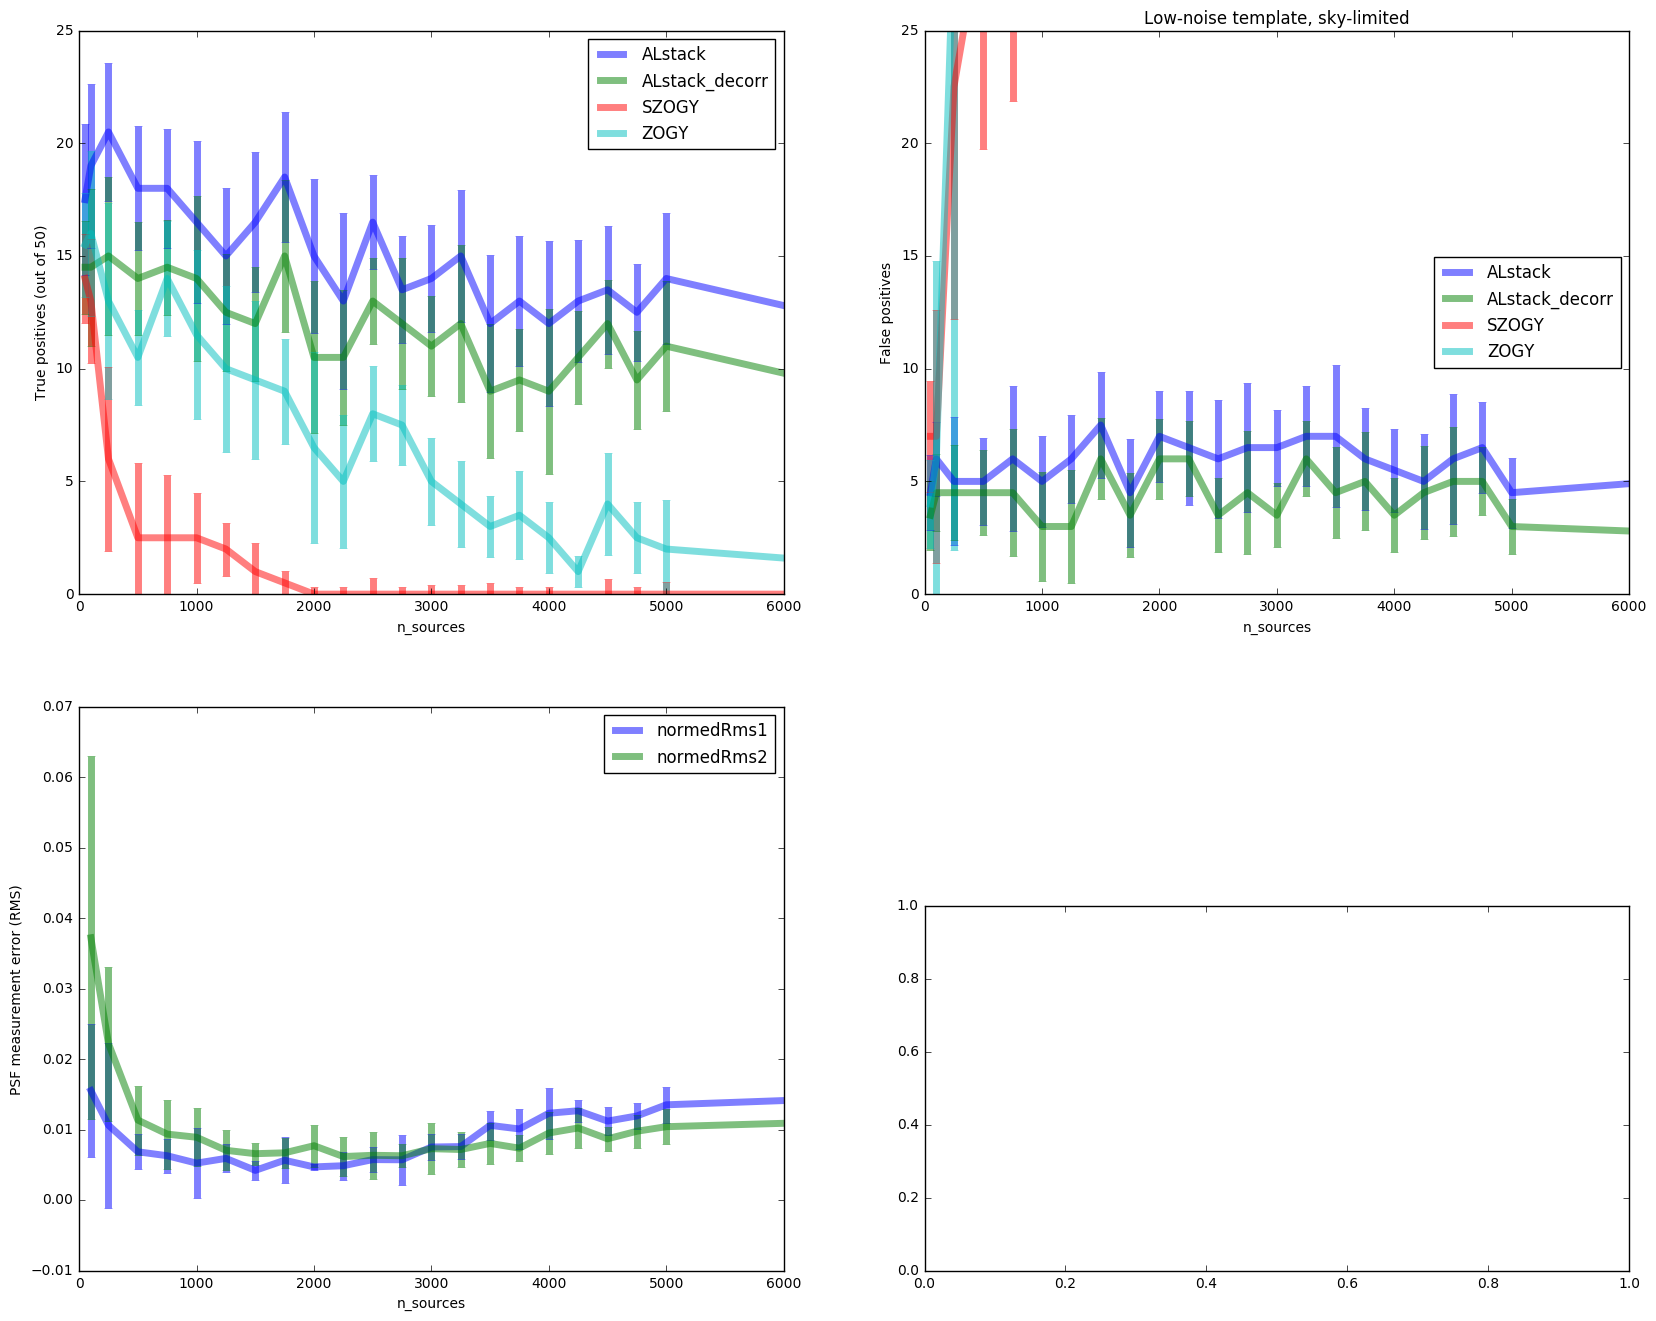

In [9]:
import pandas as pd
methods = ['ALstack', 'ZOGY', 'SZOGY', 'ALstack_decorr']

tr3 = [tr for tr in testResults3 if tr['result'] is not None]
print len(testResults3), len(tr3)

TP1 = []; FP1 = []; FN1 = []
for i, tr in enumerate(tr3):    
    rms1 = tr['psfInfo']['normedRms1']
    if rms1 is None:
        rms1 = np.nan
    rms2 = tr['psfInfo']['normedRms2']
    if rms2 is None:
        rms2 = np.nan

    TP = {key: tr['result'][key]['TP'] for key in methods}
    TP['n_sources'] = tr['n_sources']
    TP['normedRms1'] = rms1
    TP['normedRms2'] = rms2
    TP1.append(pd.DataFrame(TP, index=[0]))

    FN = {key: tr['result'][key]['FN'] for key in methods}
    FN['n_sources'] = tr['n_sources']
    FN1.append(pd.DataFrame(FN, index=[0]))

    FP = {key: tr['result'][key]['FP'] for key in methods}
    FP['n_sources'] = tr['n_sources']
    FP1.append(pd.DataFrame(FP, index=[0]))

FN1mn = pd.concat(FN1, axis=0).groupby('n_sources').median()
TP1mn = pd.concat(TP1, axis=0).groupby('n_sources').median()
FP1mn = pd.concat(FP1, axis=0).groupby('n_sources').median()

FN1err = pd.concat(FN1, axis=0).groupby('n_sources').std()
TP1err = pd.concat(TP1, axis=0).groupby('n_sources').std()
FP1err = pd.concat(FP1, axis=0).groupby('n_sources').std()

plt.subplots(3, 2, figsize=(20, 16))
ax = plt.subplot(221)    
TP1mn.drop(['normedRms1','normedRms2'], 1).reset_index().plot(x='n_sources', 
                                               yerr=TP1err.drop(['normedRms1','normedRms2'], 1), 
                                               alpha=0.5, lw=5, ax=ax)
ax.set_ylabel('True positives (out of 50)')
ax.set_xlim(0, 6000)
ax.set_ylim(0, 25)
ax = plt.subplot(222)    
FP1mn.reset_index().plot(x='n_sources', yerr=FP1err, alpha=0.5, lw=5, ax=ax)
ax.set_ylabel('False positives')
ax.set_title('Low-noise template, sky-limited')
ax.set_xlim(0, 6000)
ax.set_ylim(0, 25)

ax = plt.subplot(223)    
TP1mn[['normedRms1', 'normedRms2']].reset_index().plot(x='n_sources', 
                                                       yerr=TP1err[['normedRms1', 'normedRms2']],
                                                       alpha=0.5, lw=5, ax=ax)
ax.set_xlim(0, 6000)
ax.set_ylabel('PSF measurement error (RMS)')

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import diffimTests as dit

import warnings
warnings.filterwarnings('ignore')

In [2]:
import diffimTests_OLD as ditOLD

n_sources = 3000
sky = 300.
n_varSources = 50
flux = 620. * np.sqrt(2.)
testObj = ditOLD.DiffimTest(imSize=(512,512), sky=sky, psf1=[1.6,1.6], psf2=[1.8,2.2],
                     offset=[0,0], psf_yvary_factor=0., 
                     #varSourceChange=[1500., 1600., 1800., 2000., 2200., 2400., 2600., 2800.],
                     varFlux2=np.repeat(flux, n_varSources), variablesNearCenter=False,
                     theta1=0., theta2=-45., im2background=0., n_sources=n_sources, 
                     sourceFluxRange=(500,30000), scintillation=0.,
                     seed=66, psfSize=21, avoidBorder=False)

In [3]:
testObj2 = dit.DiffimTest(imSize=(512,512), sky=[sky, sky], psf1=[1.6,1.6], psf2=[1.8,2.2],
                     offset=[0,0], psf_yvary_factor=0., 
                     #varSourceChange=[1500., 1600., 1800., 2000., 2200., 2400., 2600., 2800.],
                     varFlux2=np.repeat(flux, n_varSources), variablesNearCenter=False,
                     theta1=0., theta2=-45., im2background=0., n_sources=n_sources, 
                     sourceFluxRange=(500,30000), scintillation=0.,
                     seed=66, psfSize=21, avoidBorder=False)

In [4]:
oldIm1 = testObj.im1
oldIm2 = testObj.im2
oldCat = testObj.centroids
newIm1 = testObj2.im1
newIm2 = testObj2.im2
newCat = testObj2.centroids
print dit.computeClippedImageStats(oldIm1.im)
print dit.computeClippedImageStats(oldIm2.im)
print dit.computeClippedImageStats(newIm1.im)
print dit.computeClippedImageStats(newIm2.im)
print
print dit.computeClippedImageStats(oldIm1.var)
print dit.computeClippedImageStats(oldIm2.var)
print dit.computeClippedImageStats(newIm1.var)
print dit.computeClippedImageStats(newIm2.var)

stats(mean=8.4880389097380178, stdev=22.084476431484372, min=-73.983335464499675, max=1678.5554912728512)
stats(mean=10.564486767645436, stdev=22.482726609073389, min=-79.062838203123192, max=1095.1123581549261)
stats(mean=8.7315249789412306, stdev=22.265886757603393, min=-77.0, max=1862.0)
stats(mean=10.825394531939828, stdev=22.751955151032956, min=-75.0, max=1242.0)

stats(mean=308.48803890973801, stdev=22.084476431484372, min=226.01666453550033, max=1978.5554912728512)
stats(mean=310.56448676764546, stdev=22.482726609073385, min=220.93716179687681, max=1395.1123581549261)
stats(mean=308.73152497894125, stdev=22.265886757603393, min=223.0, max=2162.0)
stats(mean=310.82539453193982, stdev=22.751955151032956, min=225.0, max=1542.0)


In [14]:
testObj.im1 = oldIm1
testObj.im2 = oldIm2
testObj.centroids = oldCat
testObj.reset()
testRes1 = testObj.runTest(zogyImageSpace=False)
testRes1

{'ALstack': {'FN': 33, 'FP': 4, 'TP': 17},
 'ALstack_noDecorr': {'FN': 31, 'FP': 4, 'TP': 19},
 'SZOGY': {'FN': 33, 'FP': 8, 'TP': 17},
 'ZOGY': {'FN': 31, 'FP': 6, 'TP': 19}}

In [6]:
testObj.im1 = newIm1
testObj.im2 = newIm2
testObj.centroids = newCat
testObj.reset()
testRes1a = testObj.runTest(zogyImageSpace=False)
testRes1a

{'ALstack': {'FN': 27, 'FP': 2, 'TP': 23},
 'ALstack_noDecorr': {'FN': 26, 'FP': 3, 'TP': 24},
 'SZOGY': {'FN': 32, 'FP': 9, 'TP': 18},
 'ZOGY': {'FN': 23, 'FP': 3, 'TP': 27}}

In [7]:
testObj2.im1 = newIm1
testObj2.im2 = newIm2
testObj2.centroids = newCat
testObj2.reset()
testRes2 = testObj2.runTest(zogyImageSpace=False)
testRes2

{'ALstack': {'FN': 23, 'FP': 14, 'TP': 27},
 'ALstack_decorr': {'FN': 34, 'FP': 3, 'TP': 16},
 'SZOGY': {'FN': 35, 'FP': 13, 'TP': 15},
 'ZOGY': {'FN': 31, 'FP': 8, 'TP': 19}}

In [8]:
testObj2.im1 = oldIm1
testObj2.im2 = oldIm2
testObj2.centroids = oldCat
testObj2.reset()
testRes2a = testObj2.runTest(zogyImageSpace=False)
testRes2a

{'ALstack': {'FN': 20, 'FP': 8, 'TP': 30},
 'ALstack_decorr': {'FN': 39, 'FP': 1, 'TP': 11},
 'SZOGY': {'FN': 33, 'FP': 2, 'TP': 17},
 'ZOGY': {'FN': 30, 'FP': 1, 'TP': 20}}

In [9]:
print oldCat[0:10,:]

[[ 337.71512179   71.91608075    0.          876.81240867]
 [ 488.83357365  455.02590111    0.          876.81240867]
 [ 307.05868626   49.62483321    0.          876.81240867]
 [ 408.53898573  413.07874399    0.          876.81240867]
 [ 348.83920263   31.38213953    0.          876.81240867]
 [ 122.65370308   59.63479802    0.          876.81240867]
 [ 421.53866146  207.2740583     0.          876.81240867]
 [ 141.74362116   60.72056978    0.          876.81240867]
 [ 199.01602101  205.83054644    0.          876.81240867]
 [ 386.87553501  168.78610741    0.          876.81240867]]


stats(mean=0.0067999724060859379, stdev=0.97222891677659518, min=-4.7853333989333251, max=4.5055281282226236)
stats(mean=0.16918852347486182, stdev=24.189800350693325, min=-119.06276114650376, max=112.10099164143871)
24.4948974278


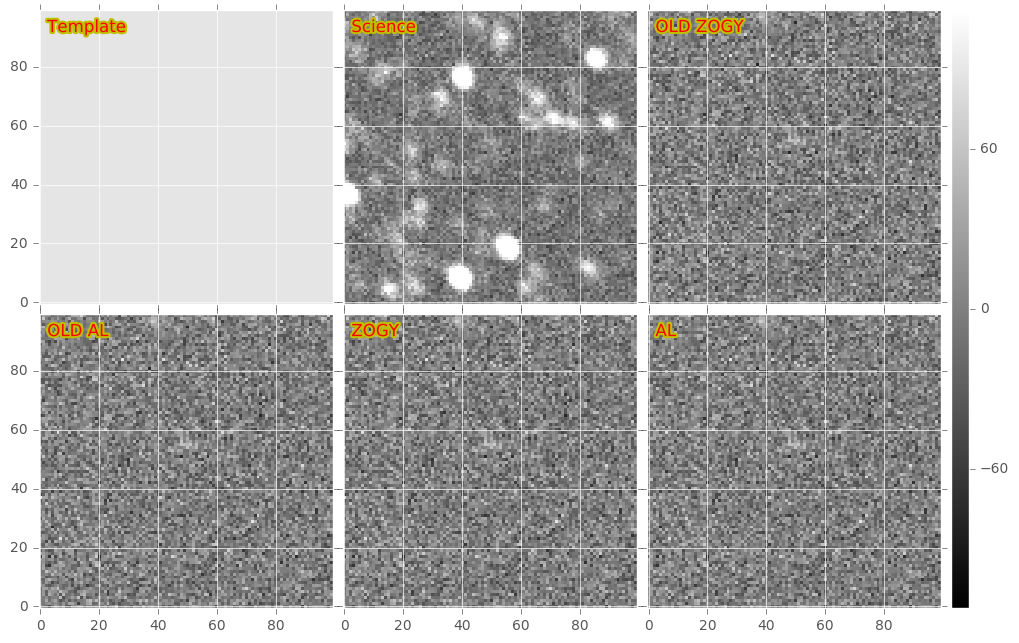

In [15]:
print dit.computeClippedImageStats(testObj.D_ZOGY.im)
print dit.computeClippedImageStats(testObj2.D_ZOGY.im)
print np.sqrt(2.) * np.sqrt(300.)

plt.figure(figsize=(12, 12))
dit.plotImageGrid((testObj.im1.im[150:250,150:250], testObj.im2.im[150:250,150:250],
                  testObj.D_ZOGY.im[150:250,150:250], testObj.res.decorrelatedDiffim[150:250,150:250],
                  testObj2.D_ZOGY.im[150:250,150:250], testObj2.ALres.decorrelatedDiffim[150:250,150:250]),
                 titles=['Template', 'Science', 'OLD ZOGY', 'OLD AL', 'ZOGY', 'AL'])

stats(mean=617.22039878560213, stdev=34.749642274156514, min=492.00012384430175, max=3373.6678494277776)
stats(mean=617.5566199465793, stdev=35.061098832926703, min=490.66651899026635, max=3059.9162702890626)
24.4948974278


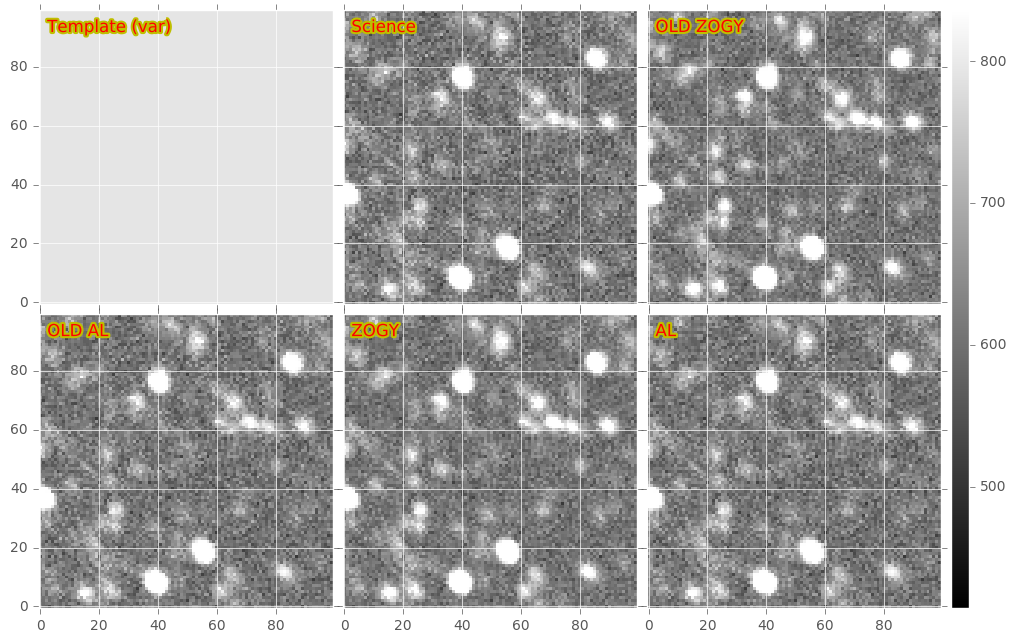

In [16]:
print dit.computeClippedImageStats(testObj.D_ZOGY.var)
print dit.computeClippedImageStats(testObj2.D_ZOGY.var)
print np.sqrt(2.) * np.sqrt(300.)

plt.figure(figsize=(12, 12))
dit.plotImageGrid((testObj.im1.var[150:250,150:250], testObj.im2.var[150:250,150:250],
                  testObj.D_ZOGY.var[150:250,150:250], testObj.res.decorrelatedDiffim.getMaskedImage().getVariance()[150:250,150:250],
                  testObj2.D_ZOGY.var[150:250,150:250], testObj2.ALres.decorrelatedDiffim.getMaskedImage().getVariance()[150:250,150:250]),
                 titles=['Template (var)', 'Science', 'OLD ZOGY', 'OLD AL', 'ZOGY', 'AL'])

In [19]:
print dit.computeClippedImageStats(testObj.D_ZOGY.im / np.sqrt(testObj.D_ZOGY.var))
print dit.computeClippedImageStats(testObj2.D_ZOGY.im / np.sqrt(testObj2.D_ZOGY.var))

stats(mean=-7.1577147016559187e-05, stdev=0.038768095369134961, min=-0.20288553888520472, max=0.17921757604254995)
stats(mean=-0.00597691150158065, stdev=0.96430157281470574, min=-5.3750528356307585, max=4.2824280043695415)


stats(mean=0.0062273361719897193, stdev=1.4019990679126724, min=-7.8534685110566027, max=7.3181313546833024)
stats(mean=0.066358827, stdev=34.556362, min=-194.38425, max=171.97018)


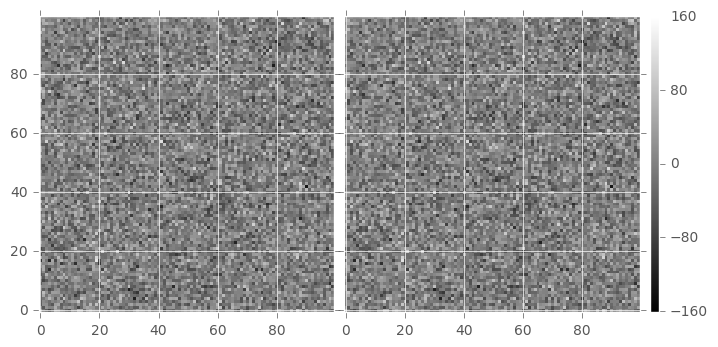

In [11]:
plt.figure(figsize=(8, 8))
diff1 = (testObj2.D_ZOGY.im/np.sqrt(2.)/np.sqrt(300.)) - testObj.D_ZOGY.im
diff2 = testObj2.ALres.decorrelatedDiffim.getMaskedImage().getImage().getArray() - \
    testObj.res.decorrelatedDiffim.getMaskedImage().getImage().getArray()
                   
print dit.computeClippedImageStats(diff1)
print dit.computeClippedImageStats(diff2)
dit.plotImageGrid((diff1[150:250,150:250], diff2[150:250,150:250]))

stats(mean=-0.15668720150385076, stdev=17.007781625864499, min=-152.88538796131638, max=313.75157913871499)


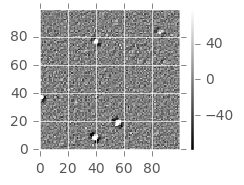

In [18]:
#plt.figure(figsize=(12, 12))
print dit.computeClippedImageStats(testObj.D_ZOGY.var - testObj2.D_ZOGY.var)
dit.plotImageGrid((#testObj.im1.var, testObj.im2.var,
                  testObj.D_ZOGY.var[150:250,150:250] - testObj2.D_ZOGY.var[150:250,150:250],))

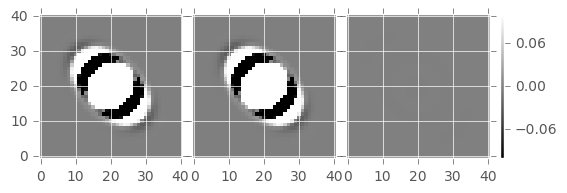

In [13]:
dit.plotImageGrid((testObj.D_ZOGY.psf, testObj2.D_ZOGY.psf, 
                  testObj.D_ZOGY.psf - testObj2.D_ZOGY.psf))

OK, here we do a test where we use everything from the "new" code *except* we are using the old code's version of the loop and measured PSF processing.

In [20]:
import multiprocessing
from joblib import Parallel, delayed
num_cores = multiprocessing.cpu_count()
if num_cores == 32:
    num_cores = 24  # lsst-dev - don't use all the cores, man.
elif num_cores == 8:
    num_cores = 3
elif num_cores == 4:
    num_cores = 2
print num_cores

3


In [21]:
def computeNormedPsfRms(psf1, psf2):
    psf1a = psf1.copy() / psf1.max()
    psf2a = psf2.copy() / psf2.max()
    weights = psf1a * psf2a   # instead of squaring either of them separately
    weights /= weights.mean()
    rms1weighted = np.sqrt(((psf1a - psf2a)**2. * weights).mean())
    return rms1weighted

In [28]:
sky = 300.

def runTest(n_sources=500, seed=66, n_varSources=50, flux=1500., scintillation=0., printErrs=False):
    out = None
    try:
        # Make the "varying density" object to fit PSFs on
        testObj = dit.DiffimTest(imSize=(512,512), sky=sky, psf1=[1.6,1.6], psf2=[1.8,2.2],
                             offset=[0,0], psf_yvary_factor=0., 
                             #varSourceChange=[1500., 1600., 1800., 2000., 2200., 2400., 2600., 2800.],
                             varFlux2=np.repeat(flux, n_varSources), variablesNearCenter=False,
                             theta1=0., theta2=-45., im2background=0., n_sources=n_sources, 
                             sourceFluxRange=(500,30000), scintillation=scintillation,
                             seed=seed, psfSize=21, avoidBorder=False)

        # Make the "constant density" object to actually run the tests on
        testObj2 = dit.DiffimTest(imSize=(512,512), sky=sky, psf1=[1.6,1.6], psf2=[1.8,2.2],
                             offset=[0,0], psf_yvary_factor=0., 
                             #varSourceChange=[1500., 1600., 1800., 2000., 2200., 2400., 2600., 2800.],
                             varFlux2=np.repeat(flux, n_varSources), variablesNearCenter=False,
                             theta1=0., theta2=-45., im2background=0., n_sources=1000, 
                             sourceFluxRange=(500,30000), scintillation=scintillation,
                             seed=seed, psfSize=21, avoidBorder=False)

        if scintillation == 0:
            testObj.astrometricOffsets[0] = testObj.astrometricOffsets[1] = 0.
            testObj2.astrometricOffsets[0] = testObj2.astrometricOffsets[1] = 0.

        testRes1 = None
        try:
            testRes1 = testObj2.runTest(zogyImageSpace=False)
        except Exception as e:
            if printErrs:
                print 'HERE1', e
            testRes1 = None
        
        psf1 = rms1 = shape1 = moments1 = inputShape1 = normedRms1 = None
        try:
            actualPsf1 = testObj.im1.psf.copy() #dit.makePsf(21, [1.6, 1.6], offset=[0., 0.], theta=0.)
            im1 = testObj.im1.asAfwExposure()
            res1 = dit.doMeasurePsf(im1, detectThresh=5.0, measurePsfAlg='psfex')
            psf1 = dit.afw.afwPsfToArray(res1.psf, im1) #.computeImage()
            psf1a = psf1.copy() #/ np.abs(psf2.getArray()).sum()
            psf1anorm = psf1a[np.abs(psf1a)>=1e-3].sum()
            psf1a /= psf1anorm
            rms1 = np.sqrt(((psf1a - actualPsf1)**2.).mean()) #* 100.
            normedRms1 = computeNormedPsfRms(psf1a, actualPsf1)
            sh = dit.afw.arrayToAfwPsf(actualPsf1).computeShape()
            inputShape1 = [sh.getDeterminantRadius(), sh.getIxx(), sh.getIyy(), sh.getIxy()]
            sh = dit.afw.afwPsfToShape(res1.psf, im1)
            shape1 = [sh.getDeterminantRadius(), sh.getIxx(), sh.getIyy(), sh.getIxy()]
            moments1 = dit.psf.computeMoments(psf1)
        except Exception as e:
            if printErrs:
                print 'HERE2', e
            psf1 = rms1 = shape1 = moments1 = inputShape1 = normedRms1 = None

        psf2 = rms2 = shape2 = moments2 = inputShape2 = normedRms2 = None
        try:
            actualPsf2 = testObj.im2.psf.copy() #dit.makePsf(21, [1.8, 2.2], offset=[0., 0.], theta=-45.)
            im2 = testObj.im2.asAfwExposure()
            res2 = dit.doMeasurePsf(im2, detectThresh=5.0, measurePsfAlg='psfex')
            psf2 = dit.afw.afwPsfToArray(res2.psf, im2) #.computeImage()
            psf2a = psf2.copy() #/ np.abs(psf2.getArray()).sum()
            psf2anorm = psf2a[np.abs(psf2a)>=1e-3].sum()
            psf2a /= psf2anorm
            rms2 = np.sqrt(((psf2a - actualPsf2)**2.).mean()) #* 100.
            normedRms2 = computeNormedPsfRms(psf2a, actualPsf2)
            sh = dit.afw.arrayToAfwPsf(actualPsf2).computeShape()
            inputShape2 = [sh.getDeterminantRadius(), sh.getIxx(), sh.getIyy(), sh.getIxy()]
            sh = dit.afw.afwPsfToShape(res2.psf, im2)
            shape2 = [sh.getDeterminantRadius(), sh.getIxx(), sh.getIyy(), sh.getIxy()]
            moments2 = dit.psf.computeMoments(psf2)
        except Exception as e:
            if printErrs:
                print 'HERE3', e
            psf2 = rms2 = shape2 = moments2 = inputShape2 = normedRms2 = None

        testRes2 = None
        try:
            testObj2.reset()
            psf1b = psf1a.copy()
            psf1b[psf1b < 0] = 0
            psf1b[0:10,0:10] = psf1b[31:41,31:41] = 0
            psf1b /= psf1b.sum()
            psf2b = psf2a.copy()
            psf2b[psf2b < 0] = 0
            psf2b[0:10,0:10] = psf2b[31:41,31:41] = 0
            psf2b /= psf2b.sum()
            testObj2.im1.psf = psf1b
            testObj2.im2.psf = psf2b
            testRes2 = testObj2.runTest(zogyImageSpace=False)
        except Exception as e:
            if printErrs:
                print 'HERE4', e
            testRes2 = None

        out = {'psf1': psf1, 'psf2': psf2,
               'inputPsf1': actualPsf1, 'inputPsf2': actualPsf2,
               'rms1': rms1, 'rms2': rms2, 
               'shape1': shape1, 'shape2': shape2,
               'inputShape1': inputShape1, 'inputShape2': inputShape2,
               'moments1': moments1, 'moments2': moments2,
               'nSources': n_sources, 'seed': seed,
               'diffimResInputPsf': testRes1, 'diffimResMeasuredPsf': testRes2,
               'normedRms1': normedRms1, 'normedRms2': normedRms2}
    except Exception as e:
        if printErrs:
            print 'HERE5', e
        pass
    return out

In [29]:
tmp = runTest(n_sources=50, seed=1, printErrs=True);
del tmp['inputPsf1'], tmp['inputPsf2'], tmp['psf1'], tmp['psf2']
tmp


  File "src/PsfexPsf.cc", line 192, in virtual std::shared_ptr<afw::detection::Psf::Image> lsst::meas::extensions::psfex::PsfexPsf::_doComputeImage(const afw::geom::Point2D &, const afw::image::Color &, const afw::geom::Point2D &) const
    Only spatial variation (ndim == 2) is supported; saw 0 {0}
lsst::pex::exceptions::InvalidParameterError: 'Only spatial variation (ndim == 2) is supported; saw 0'

HERE2 'NoneType' object has no attribute 'copy'

  File "src/PsfexPsf.cc", line 192, in virtual std::shared_ptr<afw::detection::Psf::Image> lsst::meas::extensions::psfex::PsfexPsf::_doComputeImage(const afw::geom::Point2D &, const afw::image::Color &, const afw::geom::Point2D &) const
    Only spatial variation (ndim == 2) is supported; saw 0 {0}
lsst::pex::exceptions::InvalidParameterError: 'Only spatial variation (ndim == 2) is supported; saw 0'

HERE3 'NoneType' object has no attribute 'copy'
HERE4 local variable 'psf1a' referenced before assignment


{'diffimResInputPsf': {'ALstack': {'FN': 12, 'FP': 3, 'TP': 38},
  'ALstack_decorr': {'FN': 18, 'FP': 0, 'TP': 32},
  'SZOGY': {'FN': 15, 'FP': 0, 'TP': 35},
  'ZOGY': {'FN': 7, 'FP': 1, 'TP': 43}},
 'diffimResMeasuredPsf': None,
 'inputShape1': None,
 'inputShape2': None,
 'moments1': None,
 'moments2': None,
 'nSources': 50,
 'normedRms1': None,
 'normedRms2': None,
 'rms1': None,
 'rms2': None,
 'seed': 1,
 'shape1': None,
 'shape2': None}

In [30]:
tmp = runTest(n_sources=4500, seed=2, printErrs=True);
del tmp['inputPsf1'], tmp['inputPsf2'], tmp['psf1'], tmp['psf2']
tmp

{'diffimResInputPsf': {'ALstack': {'FN': 18, 'FP': 7, 'TP': 32},
  'ALstack_decorr': {'FN': 17, 'FP': 3, 'TP': 33},
  'SZOGY': {'FN': 17, 'FP': 3, 'TP': 33},
  'ZOGY': {'FN': 11, 'FP': 3, 'TP': 39}},
 'diffimResMeasuredPsf': {'ALstack': {'FN': 18, 'FP': 7, 'TP': 32},
  'ALstack_decorr': {'FN': 17, 'FP': 3, 'TP': 33},
  'SZOGY': {'FN': 17, 'FP': 5, 'TP': 33},
  'ZOGY': {'FN': 13, 'FP': 5, 'TP': 37}},
 'inputShape1': [1.5999732062394578,
  2.5599142606841707,
  2.5599142606841707,
  0.0],
 'inputShape2': [1.989961637274519,
  4.039946238041112,
  4.039946238041112,
  -0.799989278877403],
 'moments1': (0.77694440438901446, -0.4721876915148881),
 'moments2': (0.12577202366122048, -0.098204401892700299),
 'nSources': 4500,
 'normedRms1': 0.0074242999657013276,
 'normedRms2': 0.017655577713369518,
 'rms1': 0.00029131981388739916,
 'rms2': 0.00022953805217104916,
 'seed': 2,
 'shape1': [1.5934322128598817,
  2.530555445595732,
  2.547581586555166,
  0.011930064843089292],
 'shape2': [2.000718

In [31]:
#inputs = [(i, j) for i in np.insert(np.arange(50, 5000, 100), 0, [5,10,25,35]) for j in np.arange(1, 10)]
inputs = [(i, j) for i in np.insert(np.arange(250, 5250, 500), 0, [5,10,25,35,50,100,150,200]) for j in np.arange(1, 25)]
print len(inputs)
testResults1 = Parallel(n_jobs=num_cores, verbose=2)(delayed(runTest)(n_sources=i[0], seed=i[1]) \
                                                     for i in inputs)

432

  File "src/PsfexPsf.cc", line 192, in virtual std::shared_ptr<afw::detection::Psf::Image> lsst::meas::extensions::psfex::PsfexPsf::_doComputeImage(const afw::geom::Point2D &, const afw::image::Color &, const afw::geom::Point2D &) const
    Only spatial variation (ndim == 2) is supported; saw 0 {0}
lsst::pex::exceptions::InvalidParameterError: 'Only spatial variation (ndim == 2) is supported; saw 0'


  File "src/PsfexPsf.cc", line 192, in virtual std::shared_ptr<afw::detection::Psf::Image> lsst::meas::extensions::psfex::PsfexPsf::_doComputeImage(const afw::geom::Point2D &, const afw::image::Color &, const afw::geom::Point2D &) const
    Only spatial variation (ndim == 2) is supported; saw 0 {0}
lsst::pex::exceptions::InvalidParameterError: 'Only spatial variation (ndim == 2) is supported; saw 0'


  File "src/PsfexPsf.cc", line 192, in virtual std::shared_ptr<afw::detection::Psf::Image> lsst::meas::extensions::psfex::PsfexPsf::_doComputeImage(const afw::geom::Point2D &, const afw

[Parallel(n_jobs=3)]: Done  35 tasks      | elapsed:  2.5min



  File "src/PsfexPsf.cc", line 192, in virtual std::shared_ptr<afw::detection::Psf::Image> lsst::meas::extensions::psfex::PsfexPsf::_doComputeImage(const afw::geom::Point2D &, const afw::image::Color &, const afw::geom::Point2D &) const
    Only spatial variation (ndim == 2) is supported; saw 0 {0}
lsst::pex::exceptions::InvalidParameterError: 'Only spatial variation (ndim == 2) is supported; saw 0'


  File "src/PsfexPsf.cc", line 192, in virtual std::shared_ptr<afw::detection::Psf::Image> lsst::meas::extensions::psfex::PsfexPsf::_doComputeImage(const afw::geom::Point2D &, const afw::image::Color &, const afw::geom::Point2D &) const
    Only spatial variation (ndim == 2) is supported; saw 0 {0}
lsst::pex::exceptions::InvalidParameterError: 'Only spatial variation (ndim == 2) is supported; saw 0'


  File "src/PsfexPsf.cc", line 192, in virtual std::shared_ptr<afw::detection::Psf::Image> lsst::meas::extensions::psfex::PsfexPsf::_doComputeImage(const afw::geom::Point2D &, const afw::im

[Parallel(n_jobs=3)]: Done 156 tasks      | elapsed: 11.5min



  File "src/PsfexPsf.cc", line 192, in virtual std::shared_ptr<afw::detection::Psf::Image> lsst::meas::extensions::psfex::PsfexPsf::_doComputeImage(const afw::geom::Point2D &, const afw::image::Color &, const afw::geom::Point2D &) const
    Only spatial variation (ndim == 2) is supported; saw 0 {0}
lsst::pex::exceptions::InvalidParameterError: 'Only spatial variation (ndim == 2) is supported; saw 0'


  File "src/PsfexPsf.cc", line 192, in virtual std::shared_ptr<afw::detection::Psf::Image> lsst::meas::extensions::psfex::PsfexPsf::_doComputeImage(const afw::geom::Point2D &, const afw::image::Color &, const afw::geom::Point2D &) const
    Only spatial variation (ndim == 2) is supported; saw 0 {0}
lsst::pex::exceptions::InvalidParameterError: 'Only spatial variation (ndim == 2) is supported; saw 0'


  File "src/PsfexPsf.cc", line 192, in virtual std::shared_ptr<afw::detection::Psf::Image> lsst::meas::extensions::psfex::PsfexPsf::_doComputeImage(const afw::geom::Point2D &, const afw::im

[Parallel(n_jobs=3)]: Done 359 tasks      | elapsed: 45.9min
[Parallel(n_jobs=3)]: Done 432 out of 432 | elapsed: 65.1min finished


In [35]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib

import pandas as pd
import seaborn as sns

In [61]:
def plotResults(tr, methods=['ALstack', 'SZOGY']):
    tr = [t for t in tr if t is not None]
    tr = [t for t in tr if t is not None and t['diffimResMeasuredPsf']]
    TP = pd.DataFrame({key: np.array([t['diffimResMeasuredPsf'][key]['TP'] for t in tr]) for key in methods})
    FN = pd.DataFrame({key: np.array([t['diffimResMeasuredPsf'][key]['FN'] for t in tr]) for key in methods})
    FP = pd.DataFrame({key: np.array([t['diffimResMeasuredPsf'][key]['FP'] for t in tr]) for key in methods})

    TP['nSources'] = np.array([t['nSources'] for t in tr])
    FP['nSources'] = np.array([t['nSources'] for t in tr])
    FN['nSources'] = np.array([t['nSources'] for t in tr])

    matplotlib.rcParams['figure.figsize'] = (24.0, 6.0)
    fig, axes = plt.subplots(nrows=1, ncols=2)

    tmp1 = TP[['nSources', methods[0]]]
    tmp2 = TP[['nSources', methods[1]]]
    tmp1['method'] = np.repeat(methods[0], tmp1.shape[0])
    tmp2['method'] = np.repeat(methods[1], tmp2.shape[0])
    tmp1.columns.values[1] = tmp2.columns.values[1] = 'TP'
    tmp = pd.concat((tmp1, tmp2))

    g = sns.violinplot(x='nSources', y='TP', data=tmp, split=True, hue='method', inner="box", cut=0, 
                   linewidth=0.3, bw=0.5, ax=axes[0], scale='width')
    g.set_title('True Positives')
    g.set_ylim((0, 52))
    g.set_xlabel('N sources')
    g.set_xticklabels(g.get_xticklabels(), rotation=30);

    tmp1 = FP[['nSources', methods[0]]]
    tmp2 = FP[['nSources', methods[1]]]
    tmp1['method'] = np.repeat(methods[0], tmp1.shape[0])
    tmp2['method'] = np.repeat(methods[1], tmp2.shape[0])
    tmp1.columns.values[1] = tmp2.columns.values[1] = 'FP'
    tmp = pd.concat((tmp1, tmp2))

    g = sns.violinplot(x='nSources', y='FP', data=tmp, split=True, hue='method', inner="box", cut=0, 
                   linewidth=0.3, bw=0.5, ax=axes[1], width=0.8, scale='width')
    g.set_title('False Positives')
    g.set_ylim((0, 30))
    g.set_xlabel('N sources')
    g.set_xticklabels(g.get_xticklabels(), rotation=30);
    
methods = ['ALstack', 'ZOGY', 'SZOGY', 'ALstack_noDecorr']

In [65]:
def plotPsfResults(testResults):
    ns = np.array([inputs[i][0] for i in np.arange(len(inputs)) if testResults[i] is not None])
    tr = [t for t in testResults if t is not None and t['inputPsf1'] is not None and t['psf1'] is not None]
    tr = [t for t in tr if t is not None and t['inputPsf2'] is not None and t['psf2'] is not None]
    #tr = [t for t in tr if t is not None and t['psf1'] is not None]
    #tr = [t for t in tr if t['rms1'] is not None]
    #tr = [t for t in tr if t['rms2'] is not None]
    print len(testResults), len(tr)
    ns = np.array([t['nSources'] for t in tr if t is not None])
    rms1s = [computeNormedPsfRms(t['psf1'], t['inputPsf1']) for t in tr if t is not None]
    rms2s = [computeNormedPsfRms(t['psf2'], t['inputPsf2']) for t in tr if t is not None]

    tr = {'nSources': ns,
          #'rms1': np.array([t['rms1'] for t in tr])*100.,
          #'rms2': np.array([t['rms2'] for t in tr])*100.,
          #'rad1diff': np.array([t['shape1'][0] - t['inputShape1'][0] for t in tr]),
          #'rad2diff': np.array([t['shape2'][0] - t['inputShape2'][0] for t in tr])
         }
    tr = pd.DataFrame(tr)

    tr['rms1'] = np.array(rms1s)
    tr['rms2'] = np.array(rms2s)

    matplotlib.rcParams['figure.figsize'] = (20.0, 6.0)
    fig, axes = plt.subplots(nrows=1, ncols=2)

    g = sns.violinplot(x='nSources', y='rms1', data=tr, inner="box", cut=0, linewidth=0.3, bw=0.5, scale='width', ax=axes[0])
    g.set_title('RMS (template PSF)')
    g.set_ylabel('PSF measurement error (RMS)')
    g.set_xlabel('N sources')
    g.set_xticklabels(g.get_xticklabels(), rotation=60)
    g.set_ylim(0, 0.05)

    g = sns.violinplot(x='nSources', y='rms2', data=tr, inner="box", cut=0, linewidth=0.3, bw=0.5, scale='width', ax=axes[1])
    g.set_title('RMS (science PSF)')
    g.set_ylabel('PSF measurement error (RMS)')
    g.set_xlabel('N sources')
    g.set_xticklabels(g.get_xticklabels(), rotation=60)
    g.set_ylim(0, 0.15)

432 231


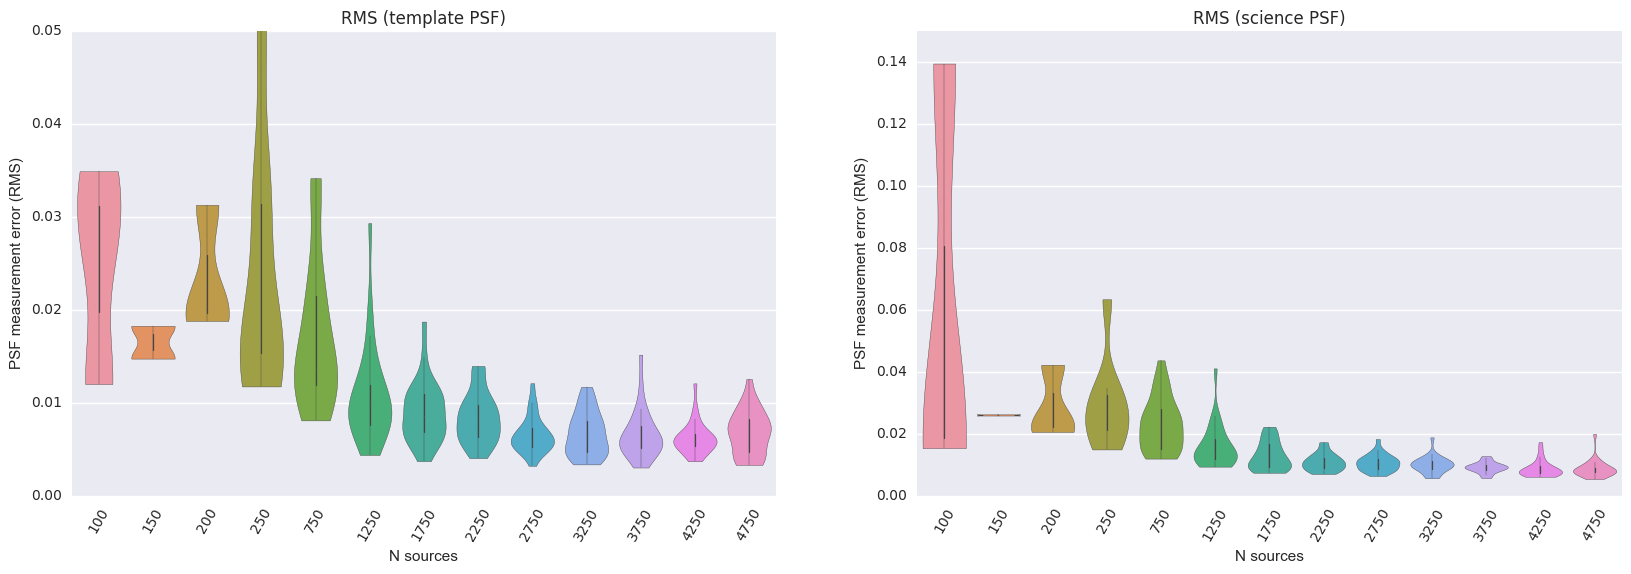

In [66]:
plotPsfResults(testResults1)

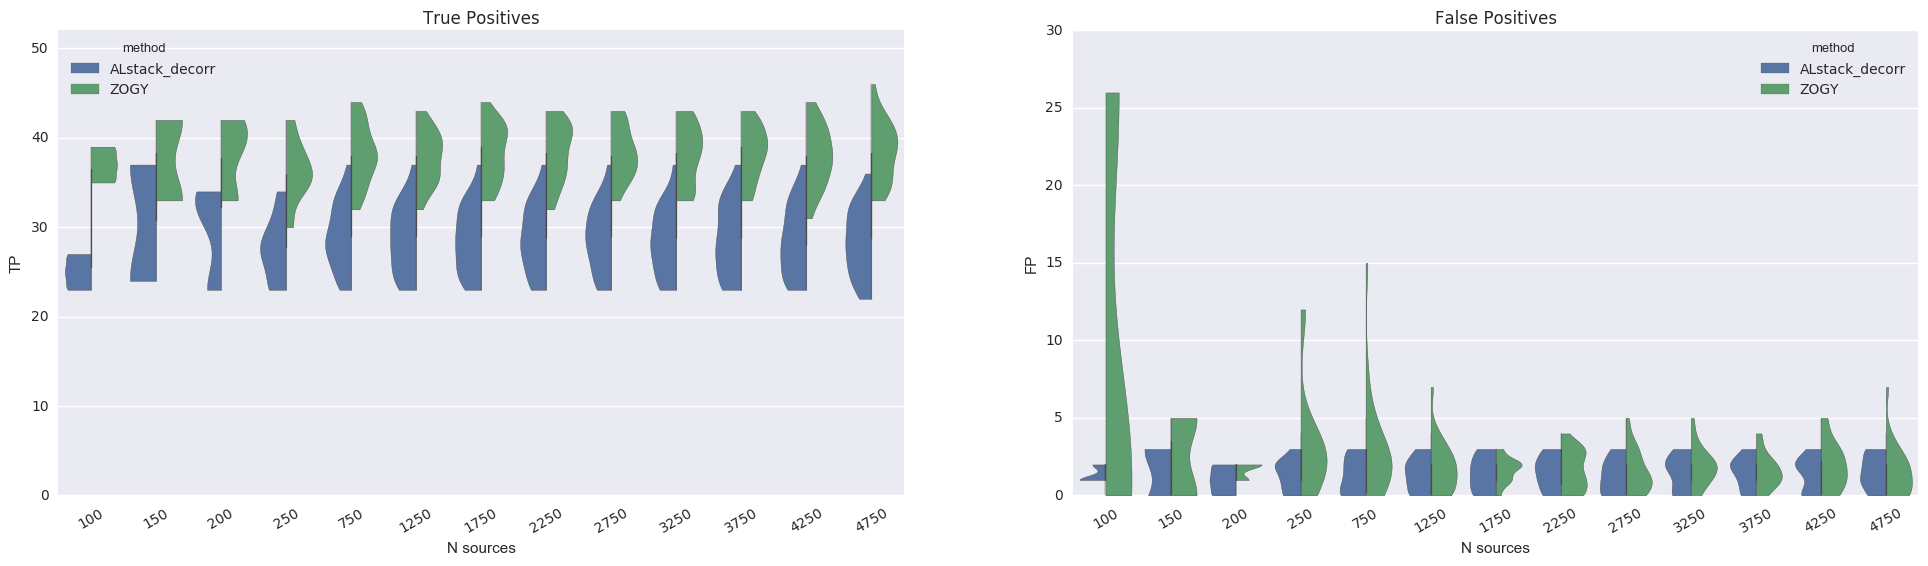

In [64]:
plotResults(testResults1, methods=['ALstack_decorr', 'ZOGY'])

Now for comparison, do everything using the OLD code.

In [46]:
def runTestOLD(n_sources=500, seed=66, n_varSources=50, flux=1500., scintillation=0., printErrs=False):
    out = None
    try:
        # Make the "varying density" object to fit PSFs on
        testObj = ditOLD.DiffimTest(imSize=(512,512), sky=sky, psf1=[1.6,1.6], psf2=[1.8,2.2],
                             offset=[0,0], psf_yvary_factor=0., 
                             #varSourceChange=[1500., 1600., 1800., 2000., 2200., 2400., 2600., 2800.],
                             varFlux2=np.repeat(flux, n_varSources), variablesNearCenter=False,
                             theta1=0., theta2=-45., im2background=0., n_sources=n_sources, 
                             sourceFluxRange=(500,30000), scintillation=scintillation,
                             seed=seed, psfSize=21, avoidBorder=False)

        # Make the "constant density" object to actually run the tests on
        testObj2 = ditOLD.DiffimTest(imSize=(512,512), sky=sky, psf1=[1.6,1.6], psf2=[1.8,2.2],
                             offset=[0,0], psf_yvary_factor=0., 
                             #varSourceChange=[1500., 1600., 1800., 2000., 2200., 2400., 2600., 2800.],
                             varFlux2=np.repeat(flux, n_varSources), variablesNearCenter=False,
                             theta1=0., theta2=-45., im2background=0., n_sources=1000, 
                             sourceFluxRange=(500,30000), scintillation=scintillation,
                             seed=seed, psfSize=21, avoidBorder=False)

        if scintillation == 0:
            testObj.astrometricOffsets[0] = testObj.astrometricOffsets[1] = 0.
            testObj2.astrometricOffsets[0] = testObj2.astrometricOffsets[1] = 0.

        testRes1 = None
        try:
            testRes1 = testObj2.runTest(zogyImageSpace=False)
        except Exception as e:
            if printErrs:
                print 'HERE1', e
            testRes1 = None
        
        psf1 = rms1 = shape1 = moments1 = inputShape1 = normedRms1 = None
        try:
            actualPsf1 = testObj.im1.psf.copy() #dit.makePsf(21, [1.6, 1.6], offset=[0., 0.], theta=0.)
            im1 = testObj.im1.asAfwExposure()
            res1 = ditOLD.measurePsf(im1, detectThresh=5.0, measurePsfAlg='psfex')
            psf1 = ditOLD.afwPsfToArray(res1.psf, im1) #.computeImage()
            psf1a = psf1.copy() #/ np.abs(psf2.getArray()).sum()
            psf1anorm = psf1a[np.abs(psf1a)>=1e-3].sum()
            psf1a /= psf1anorm
            rms1 = np.sqrt(((psf1a - actualPsf1)**2.).mean()) #* 100.
            normedRms1 = computeNormedPsfRms(psf1a, actualPsf1)
            sh = ditOLD.arrayToAfwPsf(actualPsf1).computeShape()
            inputShape1 = [sh.getDeterminantRadius(), sh.getIxx(), sh.getIyy(), sh.getIxy()]
            sh = ditOLD.afwPsfToShape(res1.psf, im1)
            shape1 = [sh.getDeterminantRadius(), sh.getIxx(), sh.getIyy(), sh.getIxy()]
            moments1 = ditOLD.computeMoments(psf1)
        except Exception as e:
            if printErrs:
                print 'HERE2', e
            psf1 = rms1 = shape1 = moments1 = inputShape1 = normedRms1 = None

        psf2 = rms2 = shape2 = moments2 = inputShape2 = normedRms2 = None
        try:
            actualPsf2 = testObj.im2.psf.copy() #dit.makePsf(21, [1.8, 2.2], offset=[0., 0.], theta=-45.)
            im2 = testObj.im2.asAfwExposure()
            res2 = ditOLD.measurePsf(im2, detectThresh=5.0, measurePsfAlg='psfex')
            psf2 = ditOLD.afwPsfToArray(res2.psf, im2) #.computeImage()
            psf2a = psf2.copy() #/ np.abs(psf2.getArray()).sum()
            psf2anorm = psf2a[np.abs(psf2a)>=1e-3].sum()
            psf2a /= psf2anorm
            rms2 = np.sqrt(((psf2a - actualPsf2)**2.).mean()) #* 100.
            normedRms2 = computeNormedPsfRms(psf2a, actualPsf2)
            sh = ditOLD.arrayToAfwPsf(actualPsf2).computeShape()
            inputShape2 = [sh.getDeterminantRadius(), sh.getIxx(), sh.getIyy(), sh.getIxy()]
            sh = ditOLD.afwPsfToShape(res2.psf, im2)
            shape2 = [sh.getDeterminantRadius(), sh.getIxx(), sh.getIyy(), sh.getIxy()]
            moments2 = ditOLD.computeMoments(psf2)
        except Exception as e:
            if printErrs:
                print 'HERE3', e
            psf2 = rms2 = shape2 = moments2 = inputShape2 = normedRms2 = None

        testRes2 = None
        try:
            testObj2.reset()
            psf1b = psf1a.copy()
            psf1b[psf1b < 0] = 0
            psf1b[0:10,0:10] = psf1b[31:41,31:41] = 0
            psf1b /= psf1b.sum()
            psf2b = psf2a.copy()
            psf2b[psf2b < 0] = 0
            psf2b[0:10,0:10] = psf2b[31:41,31:41] = 0
            psf2b /= psf2b.sum()
            testObj2.im1.psf = psf1b
            testObj2.im2.psf = psf2b
            testRes2 = testObj2.runTest(zogyImageSpace=False)
        except Exception as e:
            if printErrs:
                print 'HERE4', e
            testRes2 = None

        out = {'psf1': psf1, 'psf2': psf2,
               'inputPsf1': actualPsf1, 'inputPsf2': actualPsf2,
               'rms1': rms1, 'rms2': rms2, 
               'shape1': shape1, 'shape2': shape2,
               'inputShape1': inputShape1, 'inputShape2': inputShape2,
               'moments1': moments1, 'moments2': moments2,
               'nSources': n_sources, 'seed': seed,
               'diffimResInputPsf': testRes1, 'diffimResMeasuredPsf': testRes2,
               'normedRms1': normedRms1, 'normedRms2': normedRms2}
    except Exception as e:
        if printErrs:
            print 'HERE5', e
        pass
    return out

In [47]:
tmp = runTestOLD(n_sources=50, seed=1, printErrs=True);
del tmp['inputPsf1'], tmp['inputPsf2'], tmp['psf1'], tmp['psf2']
tmp

HERE2 No objects passed our cuts for consideration as psf stars
HERE3 No objects passed our cuts for consideration as psf stars
HERE4 local variable 'psf1a' referenced before assignment


{'diffimResInputPsf': {'ALstack': {'FN': 16, 'FP': 1, 'TP': 34},
  'ALstack_noDecorr': {'FN': 12, 'FP': 0, 'TP': 38},
  'SZOGY': {'FN': 11, 'FP': 3, 'TP': 39},
  'ZOGY': {'FN': 8, 'FP': 0, 'TP': 42}},
 'diffimResMeasuredPsf': None,
 'inputShape1': None,
 'inputShape2': None,
 'moments1': None,
 'moments2': None,
 'nSources': 50,
 'normedRms1': None,
 'normedRms2': None,
 'rms1': None,
 'rms2': None,
 'seed': 1,
 'shape1': None,
 'shape2': None}

In [48]:
tmp = runTestOLD(n_sources=4500, seed=2, printErrs=True);
del tmp['inputPsf1'], tmp['inputPsf2'], tmp['psf1'], tmp['psf2']
tmp

{'diffimResInputPsf': {'ALstack': {'FN': 16, 'FP': 1, 'TP': 34},
  'ALstack_noDecorr': {'FN': 14, 'FP': 2, 'TP': 36},
  'SZOGY': {'FN': 16, 'FP': 7, 'TP': 34},
  'ZOGY': {'FN': 11, 'FP': 2, 'TP': 39}},
 'diffimResMeasuredPsf': {'ALstack': {'FN': 16, 'FP': 1, 'TP': 34},
  'ALstack_noDecorr': {'FN': 13, 'FP': 2, 'TP': 37},
  'SZOGY': {'FN': 13, 'FP': 4, 'TP': 37},
  'ZOGY': {'FN': 13, 'FP': 6, 'TP': 37}},
 'inputShape1': [1.5999732062394578,
  2.5599142606841707,
  2.5599142606841707,
  0.0],
 'inputShape2': [1.989961637274519,
  4.039946238041112,
  4.039946238041112,
  -0.799989278877403],
 'moments1': (20.386109703551188, 20.028262980364062),
 'moments2': (20.164304864268185, 19.97624675903165),
 'nSources': 4500,
 'normedRms1': 0.0052204078338833806,
 'normedRms2': 0.0055687464049905405,
 'rms1': 0.00021083846046789006,
 'rms2': 0.00027037250325851782,
 'seed': 2,
 'shape1': [1.610656546175171,
  2.5845525228260575,
  2.603986369028538,
  -0.013806409661804504],
 'shape2': [1.9872345

In [49]:
#inputs = [(i, j) for i in np.insert(np.arange(50, 5000, 100), 0, [5,10,25,35]) for j in np.arange(1, 10)]
inputs = [(i, j) for i in np.insert(np.arange(250, 5250, 500), 0, [5,10,25,35,50,100,150,200]) for j in np.arange(1, 25)]
print len(inputs)
testResults1OLD = Parallel(n_jobs=num_cores, verbose=2)(delayed(runTestOLD)(n_sources=i[0], seed=i[1]) \
                                                     for i in inputs)

432


[Parallel(n_jobs=3)]: Done  35 tasks      | elapsed:  4.8min
[Parallel(n_jobs=3)]: Done 156 tasks      | elapsed: 21.9min
[Parallel(n_jobs=3)]: Done 359 tasks      | elapsed: 81.6min
[Parallel(n_jobs=3)]: Done 432 out of 432 | elapsed: 120.0min finished


432 218


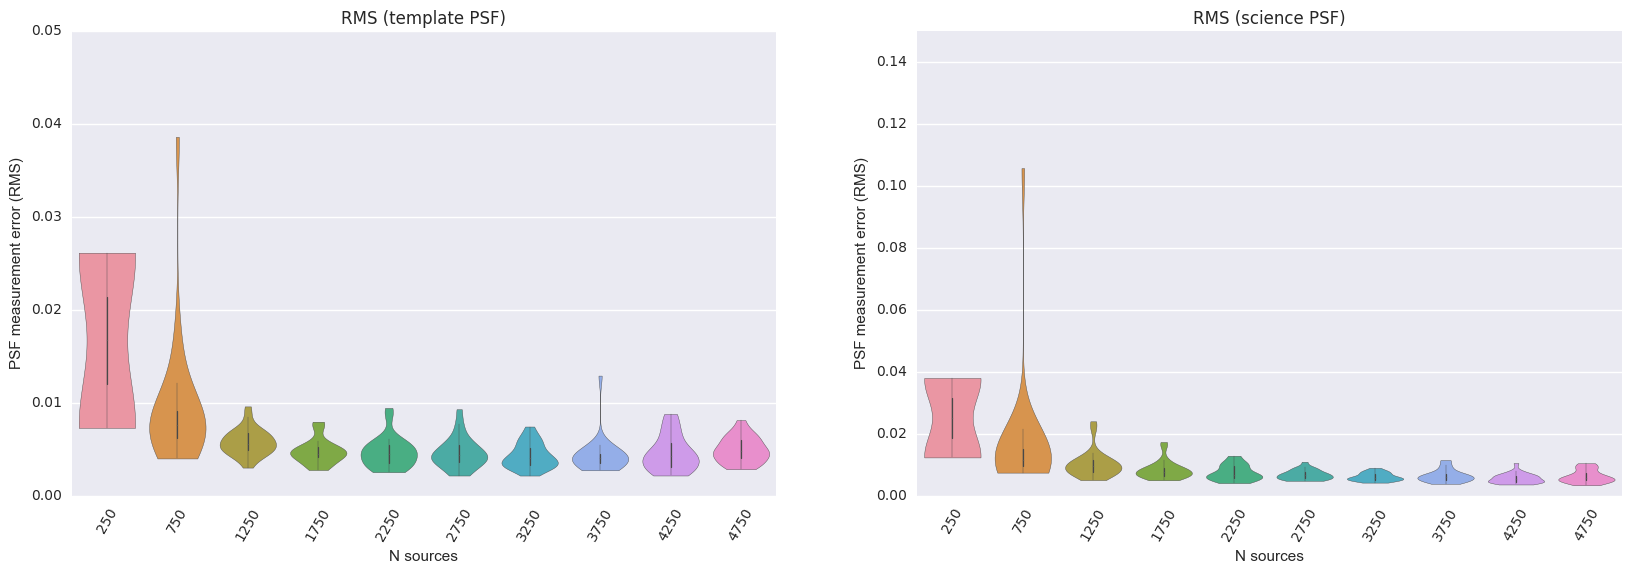

In [67]:
plotPsfResults(testResults1OLD)

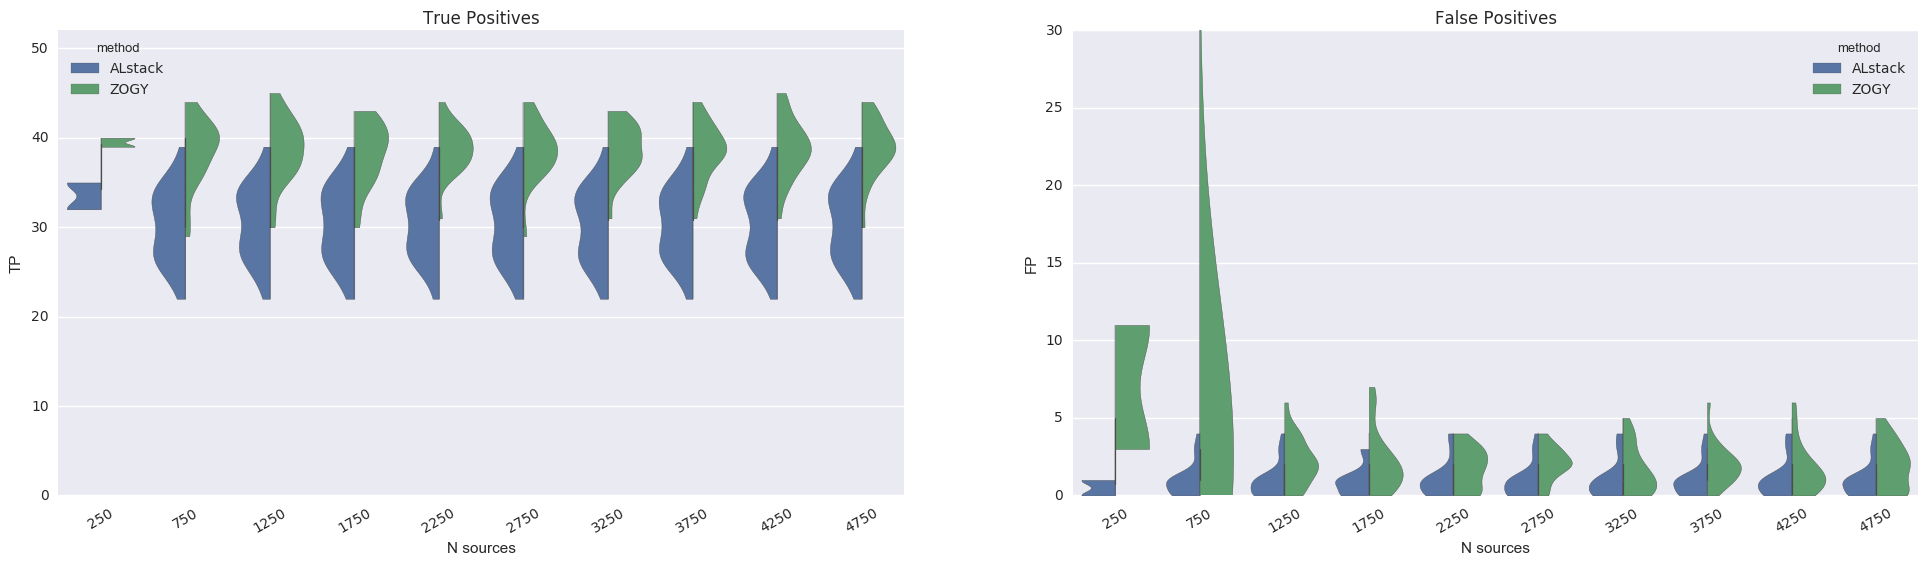

In [63]:
plotResults(testResults1OLD, methods=['ALstack', 'ZOGY'])

In [2]:
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import diffimTests as dit

import warnings
warnings.filterwarnings('ignore')

import diffimTests as dit

In [3]:
testResults = dit.multi.runTest(flux=620.*np.sqrt(2.), n_varSources=50, n_sources=4000,
                                templateNoNoise=False, skyLimited=False,
                                sky=[300., 300.], sourceFluxRange=(500,30000),
                                remeasurePsfs=[True, True], avoidAllOverlaps=0., 
                                returnObj=False, printErrs=True)

In [4]:
testResults['resultInputPsf']

{'ALstack': {'FN': 11, 'FP': 11, 'TP': 39},
 'ALstack_decorr': {'FN': 30, 'FP': 1, 'TP': 20},
 'SZOGY': {'FN': 32, 'FP': 4, 'TP': 18},
 'ZOGY': {'FN': 27, 'FP': 3, 'TP': 23}}

In [5]:
testResults['resultMeasuredPsf']

{'ALstack': {'FN': 11, 'FP': 11, 'TP': 39},
 'ALstack_decorr': {'FN': 30, 'FP': 1, 'TP': 20},
 'SZOGY': {'FN': 42, 'FP': 9, 'TP': 8},
 'ZOGY': {'FN': 30, 'FP': 30, 'TP': 20}}

In [5]:
testResults2 = dit.multi.runTest(flux=620.*np.sqrt(2.), n_varSources=50, n_sources=4000,
                                templateNoNoise=False, skyLimited=False,
                                sky=[300., 300.], sourceFluxRange=(500,30000),
                                remeasurePsfs=[True, True], avoidAllOverlaps=0., 
                                returnObj=True, printErrs=True)

In [8]:
testResults2['resultInputPsf']

{'ALstack': {'FN': 11, 'FP': 11, 'TP': 39},
 'ALstack_decorr': {'FN': 30, 'FP': 1, 'TP': 20},
 'SZOGY': {'FN': 32, 'FP': 4, 'TP': 18},
 'ZOGY': {'FN': 27, 'FP': 3, 'TP': 23}}

In [9]:
testResults2['resultMeasuredPsf']

{'ALstack': {'FN': 11, 'FP': 11, 'TP': 39},
 'ALstack_decorr': {'FN': 30, 'FP': 1, 'TP': 20},
 'SZOGY': {'FN': 42, 'FP': 9, 'TP': 8},
 'ZOGY': {'FN': 30, 'FP': 30, 'TP': 20},
 'sources': {'ALstack': <lsst.afw.table.tableLib.SourceCatalog; proxy of <Swig Object of type 'lsst::afw::table::SortedCatalogT< lsst::afw::table::SourceRecord > *' at 0x124ecf930> >,
  'ALstack_decorr': <lsst.afw.table.tableLib.SourceCatalog; proxy of <Swig Object of type 'lsst::afw::table::SortedCatalogT< lsst::afw::table::SourceRecord > *' at 0x121fe3ab0> >,
  'SZOGY': <lsst.afw.table.tableLib.SourceCatalog; proxy of <Swig Object of type 'lsst::afw::table::SortedCatalogT< lsst::afw::table::SourceRecord > *' at 0x1210c4f60> >,
  'ZOGY': <lsst.afw.table.tableLib.SourceCatalog; proxy of <Swig Object of type 'lsst::afw::table::SortedCatalogT< lsst::afw::table::SourceRecord > *' at 0x11ee22f00> >}}

The above results should not be the same!!!  And they are not.

In [5]:
n_runs = 10
ns = np.append(np.insert(np.arange(500, 5001, 250), 0, [50, 100, 250]), [7500, 10000, 15000])
testResults2 = dit.multi.runMultiDiffimTests(varSourceFlux=620., 
                                             n_varSources=50, nStaticSources=ns,
                                             templateNoNoise=False, skyLimited=False,
                                             sky=[300., 300.], sourceFluxRange=(500,30000),
                                             avoidAllOverlaps=0.,
                                             n_runs=n_runs, remeasurePsfs=[True, True])

RUNNING: 250
CORES: 4

  File "src/PsfexPsf.cc", line 192, in virtual std::shared_ptr<afw::detection::Psf::Image> lsst::meas::extensions::psfex::PsfexPsf::_doComputeImage(const afw::geom::Point2D &, const afw::image::Color &, const afw::geom::Point2D &) const
    Only spatial variation (ndim == 2) is supported; saw 0 {0}
lsst::pex::exceptions::InvalidParameterError: 'Only spatial variation (ndim == 2) is supported; saw 0'


  File "src/PsfexPsf.cc", line 192, in virtual std::shared_ptr<afw::detection::Psf::Image> lsst::meas::extensions::psfex::PsfexPsf::_doComputeImage(const afw::geom::Point2D &, const afw::image::Color &, const afw::geom::Point2D &) const
    Only spatial variation (ndim == 2) is supported; saw 0 {0}
lsst::pex::exceptions::InvalidParameterError: 'Only spatial variation (ndim == 2) is supported; saw 0'


  File "src/PsfexPsf.cc", line 192, in virtual std::shared_ptr<afw::detection::Psf::Image> lsst::meas::extensions::psfex::PsfexPsf::_doComputeImage(const afw::geom::Po

[Parallel(n_jobs=4)]: Done  17 tasks      | elapsed:   58.3s



  File "src/PsfexPsf.cc", line 192, in virtual std::shared_ptr<afw::detection::Psf::Image> lsst::meas::extensions::psfex::PsfexPsf::_doComputeImage(const afw::geom::Point2D &, const afw::image::Color &, const afw::geom::Point2D &) const
    Only spatial variation (ndim == 2) is supported; saw 0 {0}
lsst::pex::exceptions::InvalidParameterError: 'Only spatial variation (ndim == 2) is supported; saw 0'


  File "src/PsfexPsf.cc", line 192, in virtual std::shared_ptr<afw::detection::Psf::Image> lsst::meas::extensions::psfex::PsfexPsf::_doComputeImage(const afw::geom::Point2D &, const afw::image::Color &, const afw::geom::Point2D &) const
    Only spatial variation (ndim == 2) is supported; saw 0 {0}
lsst::pex::exceptions::InvalidParameterError: 'Only spatial variation (ndim == 2) is supported; saw 0'


  File "src/PsfexPsf.cc", line 192, in virtual std::shared_ptr<afw::detection::Psf::Image> lsst::meas::extensions::psfex::PsfexPsf::_doComputeImage(const afw::geom::Point2D &, const afw::im

[Parallel(n_jobs=4)]: Done  90 tasks      | elapsed:  9.6min


Weights sum to zero, can't be normalized
Weights sum to zero, can't be normalized


[Parallel(n_jobs=4)]: Done 213 tasks      | elapsed: 29.9min


Weights sum to zero, can't be normalized
Weights sum to zero, can't be normalized
Weights sum to zero, can't be normalized
Weights sum to zero, can't be normalized
Weights sum to zero, can't be normalized
Weights sum to zero, can't be normalized
Weights sum to zero, can't be normalized


[Parallel(n_jobs=4)]: Done 250 out of 250 | elapsed: 37.7min finished


FN: 
ALstack           33.450216
ALstack_decorr    35.896104
SZOGY             48.705628
ZOGY              40.575758
dtype: float64
FP: 
ALstack            4.904762
ALstack_decorr     3.744589
SZOGY             36.562771
ZOGY              97.320346
dtype: float64
TP: 
ALstack           16.549784
ALstack_decorr    14.103896
SZOGY              1.294372
ZOGY               9.424242
dtype: float64


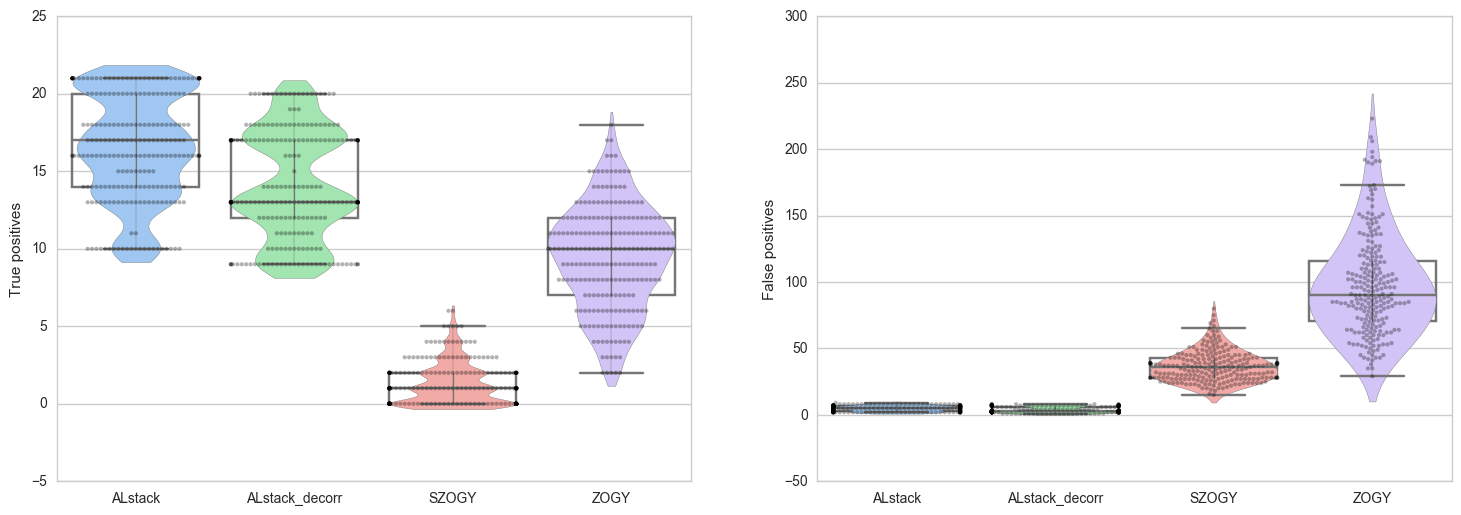

In [34]:
tr = testResults2
tr = [t for t in tr if t is not None and t['resultMeasuredPsf']]
dit.multi.plotResults(tr, resultKey='resultMeasuredPsf');

250 230


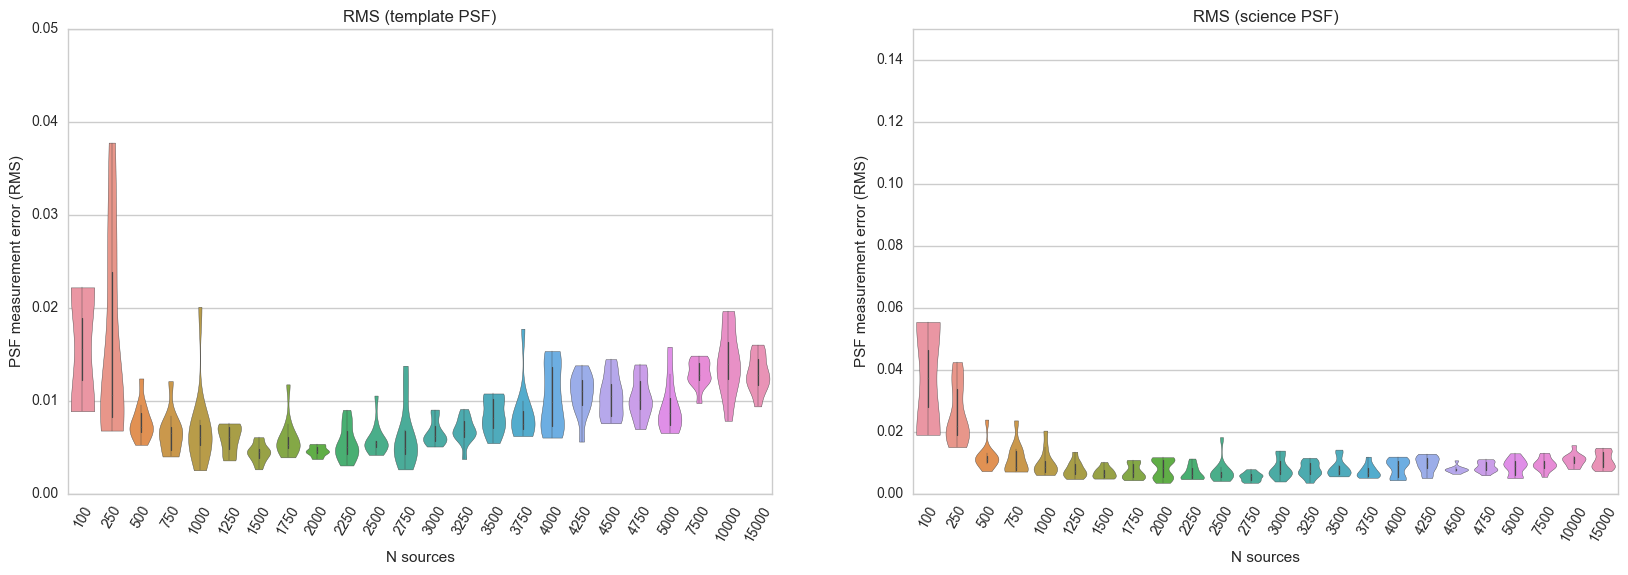

In [31]:
dit.multi.plotMeasuredPsfsResults(testResults2, resultKey='resultPsfRms')

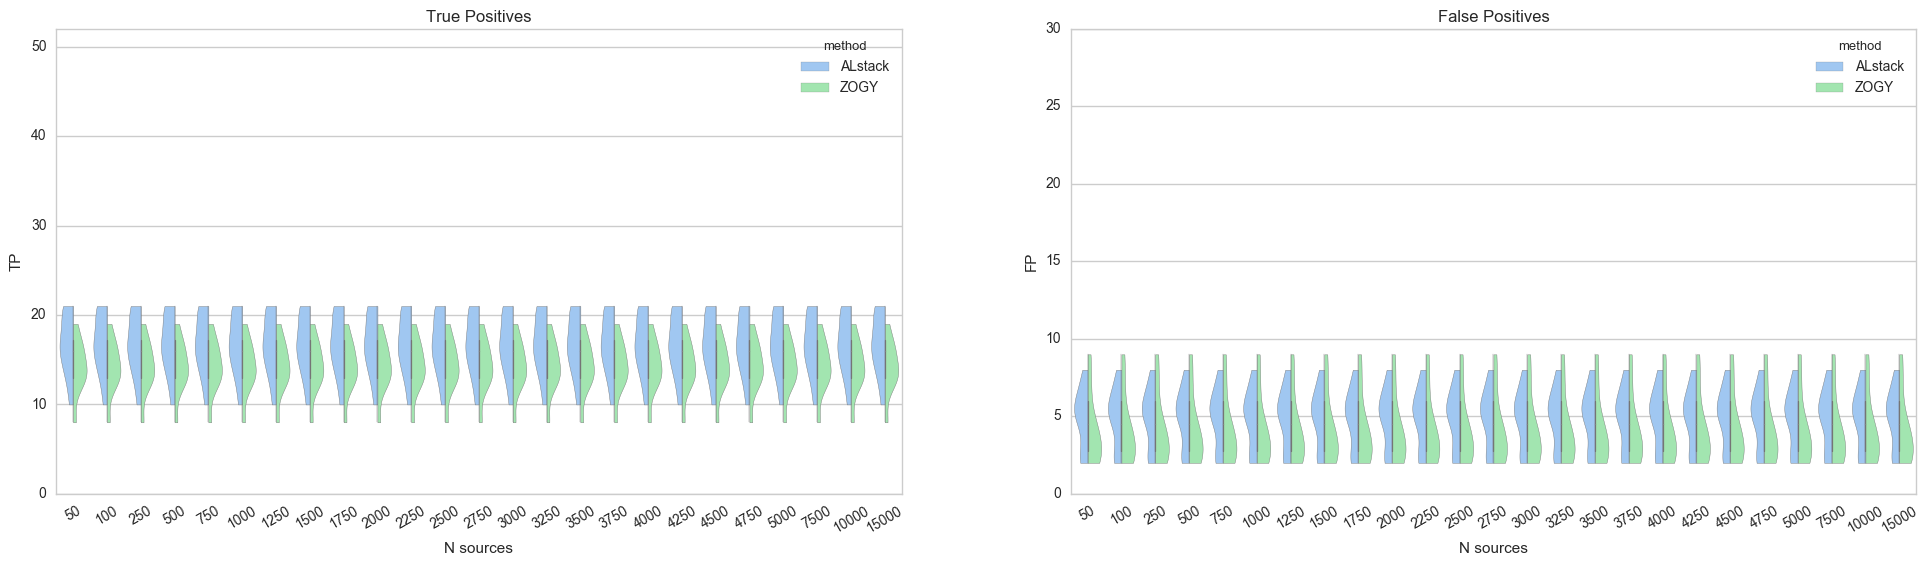

In [20]:
dit.multi.plotMeasuredPsfsResults(testResults2, resultKey='resultInputPsf')

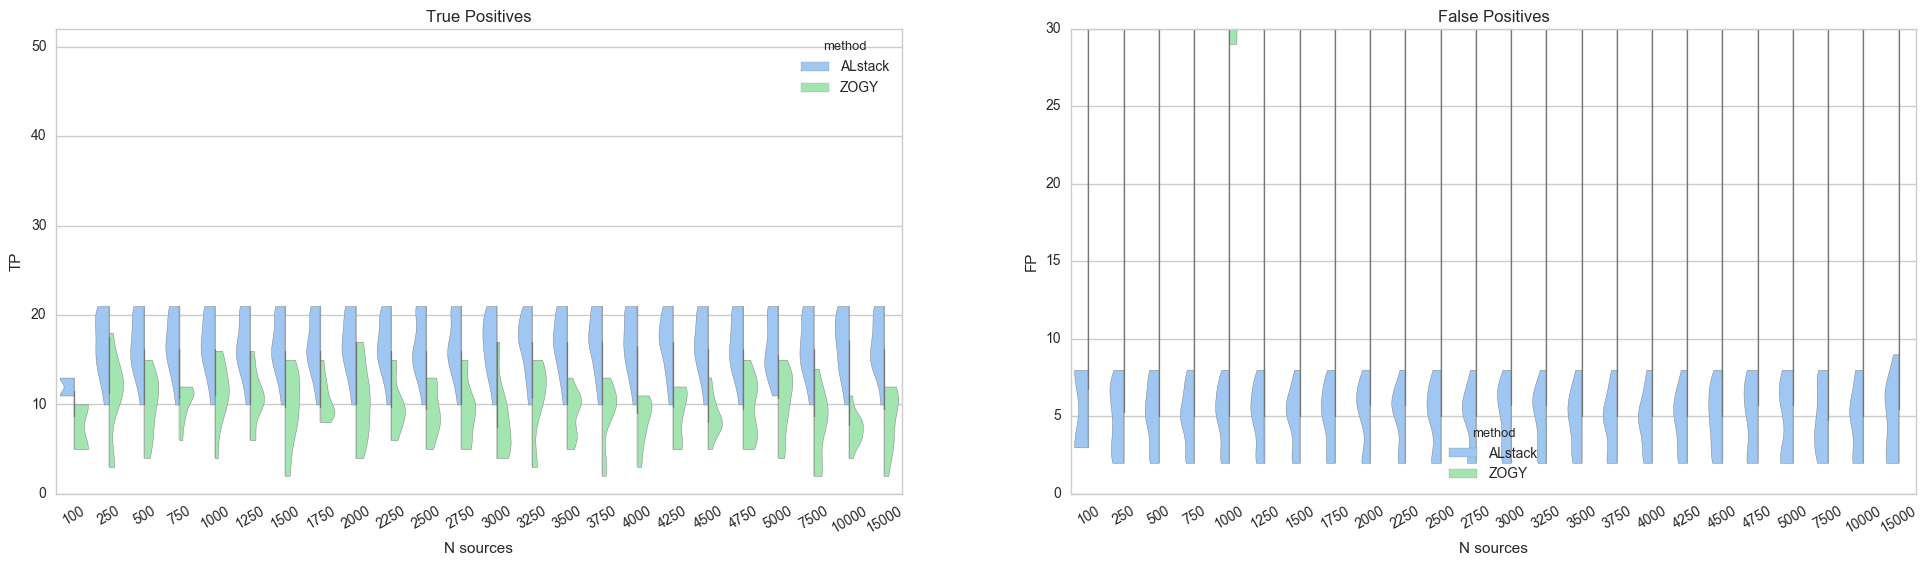

In [21]:
dit.multi.plotMeasuredPsfsResults(testResults2, resultKey='resultMeasuredPsf')

To be exact, need to use `sky=[300,300]` (used `[30,300]` above)

This test is now in Untitled4.ipynb.

In [1]:
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import diffimTests as dit

import warnings
warnings.filterwarnings('ignore')

import diffimTests as dit

In [7]:
testResults = dit.multi.runTest(flux=620.*np.sqrt(2.), n_varSources=50, n_sources=15000,
                                templateNoNoise=False, skyLimited=False,
                                sky=[300., 300.], sourceFluxRange=(500,30000),
                                remeasurePsfs=[True, True], avoidAllOverlaps=0., 
                                avoidBorder=0., returnObjs=True, printErrs=True)

In [ ]:
print testResults['resultInputPsf']
del testResults['resultMeasuredPsf']['sources']
print testResults['resultMeasuredPsf']

In [9]:
testResults2 = dit.multi.runTestORIG(flux=620.*np.sqrt(2.), n_varSources=50, n_sources=15000,
                                #templateNoNoise=False, skyLimited=False,
                                sky=[300., 300.], #sourceFluxRange=(500,30000),
                                #remeasurePsfs=[True, True], #avoidAllOverlaps=0., 
                                returnObjs=True, printErrs=True)

In [10]:
print testResults2['resultInputPsf']
print testResults2['resultMeasuredPsf']

{'ZOGY': {'FP': 2, 'FN': 24, 'TP': 26}, 'ALstack': {'FP': 9, 'FN': 21, 'TP': 29}, 'SZOGY': {'FP': 4, 'FN': 31, 'TP': 19}, 'ALstack_decorr': {'FP': 2, 'FN': 32, 'TP': 18}}
{'ZOGY': {'FP': 3, 'FN': 26, 'TP': 24}, 'ALstack': {'FP': 10, 'FN': 22, 'TP': 28}, 'SZOGY': {'FP': 4, 'FN': 32, 'TP': 18}, 'ALstack_decorr': {'FP': 2, 'FN': 32, 'TP': 18}}


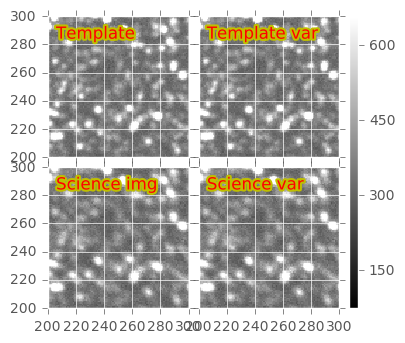

In [11]:
testResults['objs'][0].doPlot(centroidCoord=[250,250,50]);

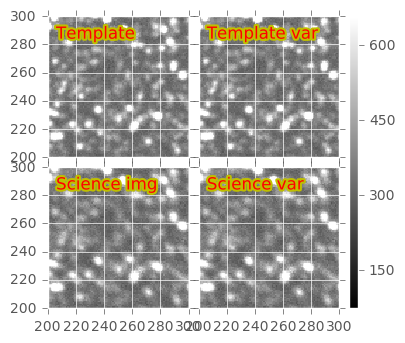

In [12]:
testResults2['objs'][0].doPlot(centroidCoord=[250,250,50]);

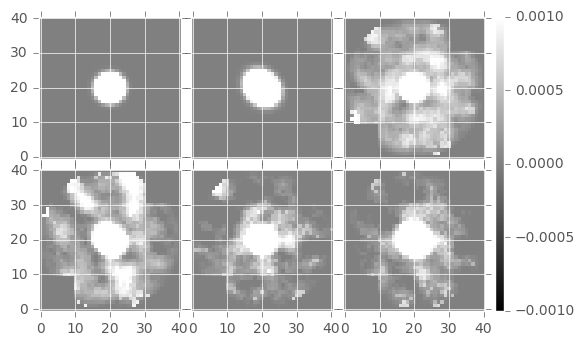

In [16]:
dit.plotImageGrid((testResults['objs'][0].im1.psf, testResults['objs'][0].im2.psf,
                   testResults['objs'][1].im1.psf, testResults['objs'][1].im2.psf,
                  testResults2['objs'][1].im1.psf, testResults2['objs'][1].im2.psf), clim=(-0.001, 0.001))